<a href="https://colab.research.google.com/github/srinijakka/W281_Final_Project/blob/main/281_FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

Import packages



In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.datasets import fetch_openml
from skimage.util import random_noise
import cv2
import os
import time
import datetime

# standard libraries
import pandas as pd
import numpy as np
import operator
import tensorflow as tf
import pathlib

# visualizations
from IPython.display import Image
%matplotlib inline

# pipelines
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import keras
import keras.utils
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers

# individual classifiers/ clustering
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.cluster import DBSCAN

# ensemble classifiers
##(not that we use a user defined class for MajorityVoting)
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# others
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone

# model fit
import statsmodels.api as sm

# visualization
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


#Dataset

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import and uncompress zipfile of image data

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/w207/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fer2013")

!unzip /content/drive/MyDrive/w207/Archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

##Reading images from the Dataset

We will be working with the open source Facial Images dataset, available on kaggle.com

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

Read images from all 7 classes of images. Use existing split of Train and Test data

In [ ]:
# Parameters for train and test directories, including the seven main classes used in this dataset

Traindirectory = "/content/train/" #training dataset
Testdirectory = "/content/test/" #training dataset

Classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"] #list of classes 

# Configuration for image size (setting to 48 x 48 pixels)
img_size = 48

#read all the images

x_train = []
x_test = []
y_train = []
y_test = []

for category in Classes:
    print(category)
    image_array=[]
    image_labels=[]

    path = os.path.join(Traindirectory, category)
    for img in os.listdir(path):
#        print(img)
        image = cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(path, img)), (img_size, img_size)), cv2.COLOR_BGR2RGB)[:,:,0]
        image_array.append(image)
        image_labels.append(Classes.index(category))

    x_train.extend(image_array) 
    y_train.extend(image_labels)
    print("Train:", len(image_labels))

    image_array=[]
    image_labels=[]
    path = os.path.join(Testdirectory, category)
    for img in os.listdir(path):
#        print(img)
        image = cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(path, img)), (img_size, img_size)), cv2.COLOR_BGR2RGB)[:,:,0]
        image_array.append(image)
        image_labels.append(Classes.index(category))

    x_test.extend(image_array) 
    y_test.extend(image_labels)
    print("Test:", len(image_labels))

image_array=[]
image_labels=[]

angry
Train: 3995
Test: 958
disgust
Train: 436
Test: 111
fear
Train: 4097
Test: 1024
happy
Train: 7215
Test: 1774
neutral
Train: 4965
Test: 1233
sad
Train: 4830
Test: 1247
surprise
Train: 3171
Test: 831


#Exploratory Data Analysis (EDA)

In this section of the python notebook, we will analyze the images in each class and identify non-facial images and duplicates in each class as well as images that are cross labelled across classes.

In [ ]:
# Data is under ./dataset/
# Set the path for the data loading
train_dir = './train/'
test_dir = './test/'

# Each image has 48x48 pixels
row, col = 48, 48
# 7 categories are under the dataset
classes = 7

# define a function for counting the number of images under the path and return a dataframe
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

display(train_count)

display(test_count)

,fear,happy,surprise,sad,disgust,angry,neutral
train,4097,7215,3171,4830,436,3995,4965


,fear,happy,surprise,sad,disgust,angry,neutral
test,1024,1774,831,1247,111,958,1233


In [ ]:
# Define a function for loading data
def load_exp(path, train_only = 0):
    '''Data loading function
        X: Image data (flattened 48x48 matrix)
        Y: Label of the data (expression category)
        Z: Saving path and filename
    '''
    Y = list() 
    Z= list()  
    emotion = []
    if train_only == 0:  # 1/2 options for loading 1)both 'train' and 'test'(Non-zero value)
        set_names = ['test','train']
        train_dir = path + 'train/'
        test_dir  = path + 'test/'
        #print( train_dir)
        num = count_exp(train_dir, 'train').loc['train'].sum() + count_exp(test_dir, 'test').loc['test'].sum() 
        # number of total files under the path
        X = np.zeros((num,48*48)) # Define X for saving image data with size calculated 1 line above
    else:                # 2/2 options for loading 2)'train' only(0) 
        set_names = ['train']
        train_dir = path + 'train/'
        num = count_exp(train_dir, 'train').loc['train'].sum() # number of total files under the path
        X = np.zeros((int(num),48*48))
    
    i=0
    #print(set_names)
    for set_name in set_names:
        for expression in os.listdir(path+'/'+set_name):
            dir_ = path +set_name+'/'+ expression
            print(dir_) # print where the data is loading from
            for file in os.listdir(dir_):
                #print(dir_+'/'+file)
                X[i,:] = cv2.imread(dir_+'/'+file)[:,:,0].flatten()
                Y.append(expression)
                i += 1
                Z.append(set_name+'/'+ expression+'/' +file)
            
    return X,Y,Z

X,Y,Z = load_exp('./',0)

./test/fear
./test/happy
./test/surprise
./test/sad
./test/disgust
./test/angry
./test/neutral
./train/fear
./train/happy
./train/surprise
./train/sad
./train/disgust
./train/angry
./train/neutral


In [ ]:
# Separate each data set by label

# happy sets
happy_set = X[[i for i, expression in enumerate(Y) if expression =='happy']]
print(happy_set.shape)

# sad sets
sad_set = X[[i for i, expression in enumerate(Y) if expression =='sad']]
print(sad_set.shape)

# fear sets
fear_set = X[[i for i, expression in enumerate(Y) if expression =='fear']]
print(fear_set.shape)

# surprise sets
surprise_set = X[[i for i, expression in enumerate(Y) if expression =='surprise']]
print(surprise_set.shape)

# neutral sets
neutral_set = X[[i for i, expression in enumerate(Y) if expression =='neutral']]
print(neutral_set.shape)

# angry sets
angry_set = X[[i for i, expression in enumerate(Y) if expression =='angry']]
print(angry_set.shape)

# disgust sets
disgust_set = X[[i for i, expression in enumerate(Y) if expression =='disgust']]
print(disgust_set.shape)

(8989, 2304)
(6077, 2304)
(5121, 2304)
(4002, 2304)
(6198, 2304)
(4953, 2304)
(547, 2304)


###Bar chart - Total per Class

<function matplotlib.pyplot.show>

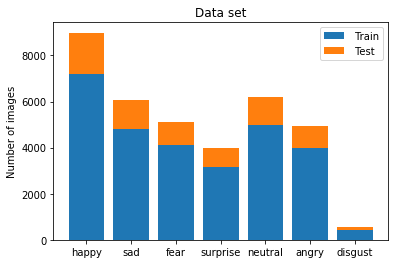

In [ ]:
## Bar chart for how many data exists for each category in 'train' and 'test'
x = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
fig, ax = plt.subplots()
ax.bar(x,train_count[x].loc['train'], width=0.8, label=' Train' )
ax.bar(x,test_count[x].loc['test']  , width=0.8, bottom=train_count[x].loc['train'], label=' Test' )
ax.set_ylabel('Number of images')
ax.set_title('Data set')
ax.legend()
plt.show

In [ ]:
# The data set consist of 80% of train data and 20% of test data
df = 0
df = pd.DataFrame()
df = train_count[x].append(test_count)
df.loc['total'] = df.sum()
df

,happy,sad,fear,surprise,neutral,angry,disgust
train,7215,4830,4097,3171,4965,3995,436
test,1774,1247,1024,831,1233,958,111
total,8989,6077,5121,4002,6198,4953,547


**Non-facial image labeling**<br>
Manually label Non-facial images in Angry_set. Use these small data set for teach KNN model and detect Non-facial images from whole data set.

In [ ]:
## Manually went through 'Angry set' to find Non-facial images
''' Below are list of Non-facial images' file name
'PrivateTest_26784100', #letter
'PublicTest_5543497',  #black
'Training_5645946',  #black
'Training_10131352', #black
'Training_22407840', #loading
'Training_25739285', #black
'Training_28756096', #black
'Training_32571770', #black
'Training_52563817', #black
'Training_67604214', #letter
'Training_78540321', #black
'Training_84260061', #loading
'Training_87875595', #letter
'Training_93307158', #letter
'Training_96772745', #black
'Training_99531165'  #black
'''

## Label Non-facial images
angry_path = [i for i, expression in enumerate(Y) if expression =='angry']

nf_black = ['PublicTest_5543497',  #black
            'Training_5645946',  #black
            'Training_10131352', #black
            'Training_25739285', #black
            'Training_28756096', #black
            'Training_32571770', #black
            'Training_52563817', #black
            'Training_78540321', #black
            'Training_96772745', #black
            'Training_99531165'  #black
           ]
nf_letters = ['PrivateTest_26784100', #letter
             'Training_67604214', #letter
             'Training_87875595', #letter
             'Training_93307158', #letter
            ]
nf_loading = ['Training_22407840', #loading
              'Training_84260061', #loading
             ]

black = []
letters = []
loading = []

# Find indices for each non-facial images
for i in range(angry_set.shape[0]):
    if any(file in Z[angry_path[i]] for file in nf_black):
        black.append(i)
    elif any(file in Z[angry_path[i]] for file in nf_letters):
        letters.append(i)
    elif any(file in Z[angry_path[i]] for file in nf_loading):
        loading.append(i)
           
# Print indices of each category
print(black)
print(letters)
print(loading)

# letters = [562, 974, 3552, 4108]
# black = [638, 1121, 1415, 1434, 1848, 2145, 2561, 2630, 3814, 3863]
# loading = [1684, 2489]

# Merge above labels into 'angry_label'
angry_label =[]
for i in range(angry_set.shape[0]):
    
    if i in black:
        angry_label.append('black')
        #print(i)
    elif i in letters:
        angry_label.append('letters')
    elif i in loading:
        angry_label.append('loading')
    else:
        angry_label.append('face')

len(angry_label)


## Found 10 black images, 4 letters images, 2 loading images

[649, 1016, 1210, 2010, 2418, 2512, 2760, 3549, 3661, 4170]
[634, 1872, 3496, 3513]
[2589, 3240]


4953

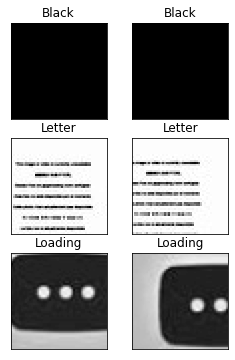

In [ ]:
# Print examples of 3 categories Non-facial images
plt.rc('image', cmap='gray')
plt.figure(figsize=(4, 6))
for i in range(6):
    
    plt.subplot(3,2,i+1)
    ax=plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if i < 2:
        plt.imshow(angry_set[black[i+2],:].reshape(48,48))
        ax.set_title('Black')
    elif i < 4:
        plt.imshow(angry_set[letters[i-2],:].reshape(48,48))
        ax.set_title('Letter')
    elif i < 6:
        plt.imshow(angry_set[loading[i-4],:].reshape(48,48))
        ax.set_title('Loading')

###Non-facial Image Detection

####Loading Image detection
Using KNN for histogram of images

In [ ]:
## Convert images to histogram
## define histogram variables for 'Angry_set', and 'X'(Whole dataset)
ang_hist = np.empty((angry_set.shape[0], len(np.arange(256))))
X_hist = np.empty((X.shape[0], len(np.arange(256))))

## Convert images to histogram
for i in range(angry_set.shape[0]):
    ang_hist[i,:] = np.histogram(angry_set[i,:], bins = np.arange(257))[0]
    
for i in range(X.shape[0]):
    X_hist[i,:] = np.histogram(X[i,:], bins = np.arange(257))[0]

**Observations**  
Histogram of images: <br>
1) Regular facial images have widely distributed histogram<br>
2) Black images have mostly black(0) and very little other tones<br>
3) Letter images have mostly white(255) and very little other tones<br>
4) Loading images have mostly bimodal distribution (some grays and some blacks)

[64, 2010, 1872, 3240]

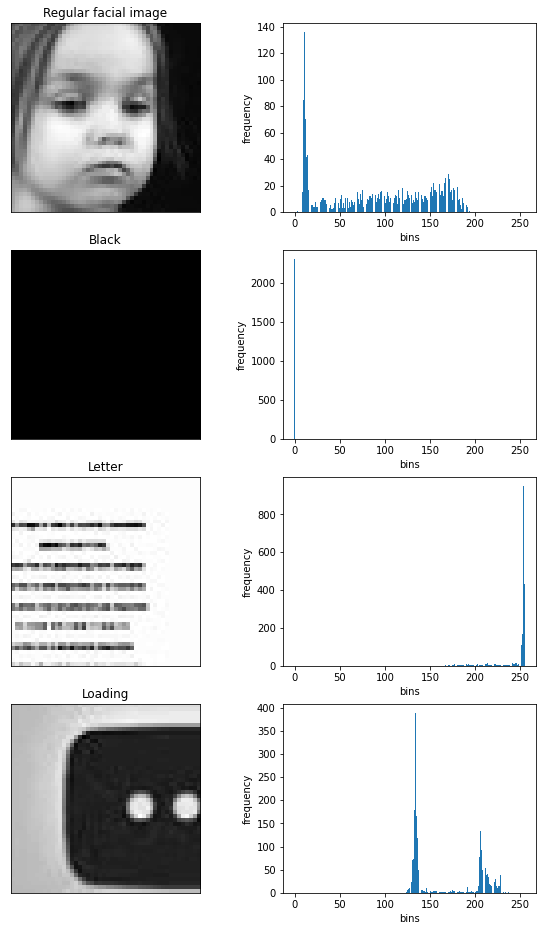

In [ ]:

hist_example = [64, black[3], letters[1], loading[1]]
display(hist_example)
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 16))

for i in range(4):    
    ax = plt.subplot(4,2,2*i+1)
    #ax.set_title('raw img')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(angry_set[hist_example[i],:].reshape(48,48))

    ax2 = plt.subplot(4,2,2*i+2)
    ax2.bar(range(256),ang_hist[hist_example[i],:])
    #ax2.set_title('histogram')
    ax2.set_ylabel('frequency')
    ax2.set_xlabel('bins')
    if i ==0:
        ax.set_title('Regular facial image')
    elif i == 1:
        ax.set_title('Black')
    elif i == 2:
        ax.set_title('Letter')
    elif i == 3:
        ax.set_title('Loading')

Training and predict 'black' images

In [ ]:
hist_filt = KNeighborsClassifier(n_neighbors=1)
hist_filt.fit(ang_hist, angry_label)
prediction = hist_filt.predict(X_hist)
letter_KNN_hist_idx = []
black_KNN_hist_idx = []
loading_KNN_hist_idx = []
i=0
for label in prediction:
    if label == 'letters':
        letter_KNN_hist_idx.append(i)
    elif label == 'black':
        black_KNN_hist_idx.append(i)
    elif label == 'loading':
        loading_KNN_hist_idx.append(i)
    i+=1

print("black",len(black_KNN_hist_idx))
print("letters",len(letter_KNN_hist_idx))
print("loading",len(loading_KNN_hist_idx))

## detection result from KNN raw images
## black 21
## letters 15
## loading 11

black 21
letters 15
loading 11


Print detected 'loading' images
$\Rightarrow$ Detected 11 images

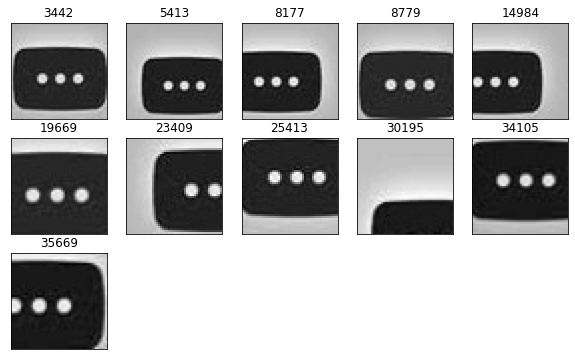

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(loading_KNN_hist_idx)//5))
#start = 300
for k in range(len(loading_KNN_hist_idx)):
    plt.subplot(len(loading_KNN_hist_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(loading_KNN_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[loading_KNN_hist_idx[k],:].reshape(48,48))


#### Letter image detection
Using KNN for Fourier transformed images.

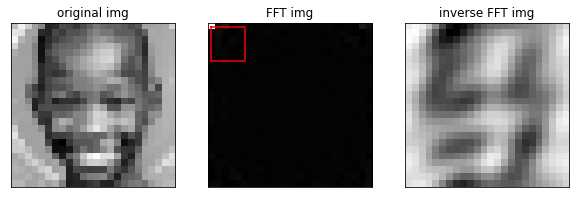

In [ ]:
# example of FFT
from scipy import fftpack
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 30))
# pick a random image
ran_num = np.random.randint(X.shape[0])
example_img = cv2.resize(X[ran_num,:].reshape(48,48),(24,24)) # resize the img to 24x24(1/4 size of the original)
# plotting original image
plt.subplot(1,3,1)
ax = plt.gca()
ax.set_title('original img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_img)

# Fourier transform the image
example_fft = fftpack.fft2(example_img)
# plotting original image
plt.subplot(1,3,2)
ax = plt.gca()
ax.set_title('FFT img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_fft.real)
plt.plot([0,5,5,0,0], [0,0,5,5,0], color = 'red')

# Take only 5x5 of the FFT matrix and make the rest to 0
# It has an effect of Low Pass Filtering
example_fft[5:,:] = 0
example_fft[:,5:] = 0

# Inverse Fourier transform the 5x5 matrix3
example_ifft = np.fft.ifft2(example_fft)
plt.subplot(1,3,3)
ax = plt.gca()
ax.set_title('inverse FFT img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_ifft.real)

In [ ]:
## Convert images to Fourier transformed frequency domain
## define variables to save Fourier transformed 'Angry_set', and 'X'(Whole dataset)
angry_FFT = []
X_FFT = []

## convert angry_set data
for i in range(angry_set.shape[0]):
    img_fft = fftpack.fft2(cv2.resize(angry_set[i,:].reshape(48,48),(24,24)))
    angry_FFT.append((img_fft.real[:5,:5]).flatten()) # only take 5x5 of the FFT transformed data
    
angry_FFT = np.array(angry_FFT)


## convert the whole data set X
for i in range(X.shape[0]):
    img2_fft = fftpack.fft2(cv2.resize(X[i,:].reshape(48,48),(24,24)))
    X_FFT.append((img2_fft.real[:5,:5]).flatten())

X_FFT = np.array(X_FFT)

Training and predict 'letter' images

In [ ]:
filters_FFT = KNeighborsClassifier(n_neighbors=1)
filters_FFT.fit(angry_FFT, angry_label)
prediction = filters_FFT.predict(X_FFT)
letter_FFT_idx = []
black_FFT_idx = []
loading_FFT_idx = []
i=0
for label in prediction:
    if label == 'letters':
        letter_FFT_idx.append(i)
    elif label == 'black':
        black_FFT_idx.append(i)
    elif label == 'loading':
        loading_FFT_idx.append(i)
    i+=1

print("black",len(black_FFT_idx))
print("letters",len(letter_FFT_idx))
print("loading",len(loading_FFT_idx))

black 16
letters 27
loading 27


Print detected 'letter' images 
$\Rightarrow$ Detected 27 images

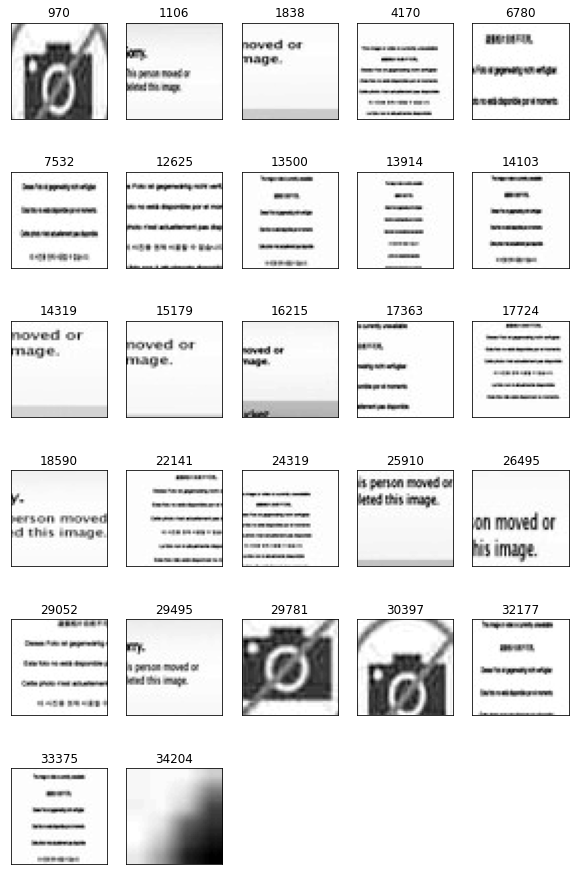

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(letter_FFT_idx)//5))

for k in range(len(letter_FFT_idx)):
    plt.subplot(len(letter_FFT_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(letter_FFT_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[letter_FFT_idx[k],:].reshape(48,48))
plt.show()

#### Black image detection
Using KMean for histogram of images

In [ ]:
# made same 10 clusters
km = KMeans(n_clusters=10,
           #init='random',
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

# predict k-means classes for histogram data
y_km_hist = km.fit_predict(X_hist)

# print clusters and the number of data in a cluster
unique, counts = np.unique(y_km_hist, return_counts=True)
dict(zip(unique, counts))

{0: 7381,
 1: 5777,
 2: 441,
 3: 24,
 4: 1519,
 5: 4996,
 6: 1901,
 7: 5514,
 8: 257,
 9: 8077}

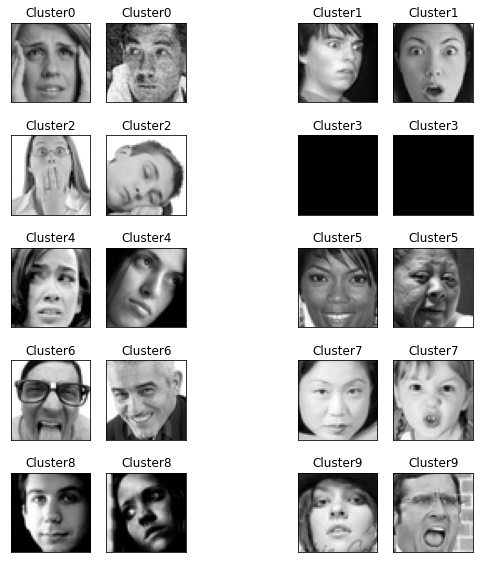

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 10))
#start = 300
for k in range(10):
    y_km_idx = np.argwhere(y_km_hist == k)
    plt.subplot(5,6,3*k+1)
    ax = plt.gca()
    ax.set_title('Cluster'+str(k))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    idx = np.random.randint(0, len(y_km_idx))
    plt.imshow(X[y_km_idx[idx][0],:].reshape(48,48))
    
    plt.subplot(5,6,3*k+2)
    ax = plt.gca()
    ax.set_title('Cluster'+str(k))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    idx = np.random.randint(0, len(y_km_idx))
    plt.imshow(X[y_km_idx[idx][0],:].reshape(48,48))

**Cluster #3 shows the black images** $\Rightarrow$



/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


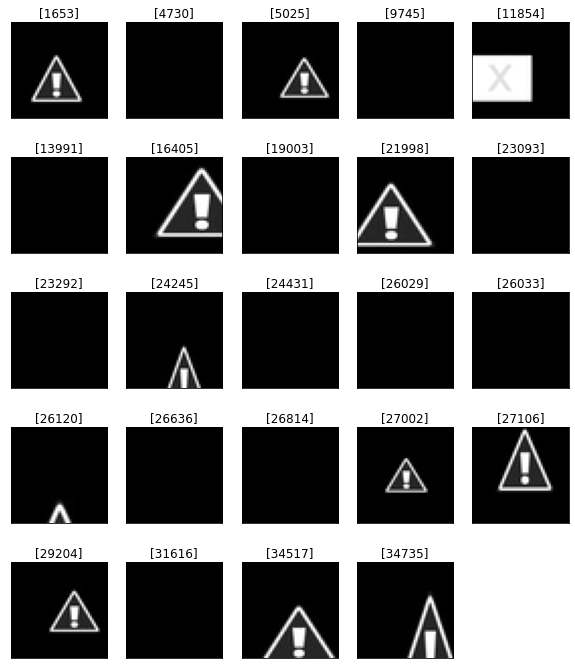

In [ ]:
# save indices for cluster 3
y_km_hist_idx = np.argwhere(y_km_hist==3)
# show all images in cluster 3
plt.rc('image', cmap='gray')
##y_km_hist_idx = np.argwhere(y_km==unique[counts==24][0]) # black images
plt.figure(figsize=(10, 3*y_km_hist_idx.shape[0]//6))
for k in range(y_km_hist_idx.shape[0]):
    plt.subplot(y_km_hist_idx.shape[0]//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(y_km_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_km_hist_idx[k],:].reshape(48,48))

In [ ]:
# The 'y_km_hist_idx' has nested list 
# below function will flatten the nested structure
def flattenList(nestedList):
    # check if list is empty
    if not(bool(nestedList)):
        return nestedList
  
     # to check instance of list is empty or not
    if isinstance(nestedList[0], list):
  
        # call function with sublist as argument
        return flattenList(*nestedList[:1]) + flattenList(nestedList[1:])
  
    # call function with sublist as argument
    return nestedList[:1] + flattenList(nestedList[1:])

filter_black = flattenList(y_km_hist_idx.tolist())
print(filter_black)

[1653, 4730, 5025, 9745, 11854, 13991, 16405, 19003, 21998, 23093, 23292, 24245, 24431, 26029, 26033, 26120, 26636, 26814, 27002, 27106, 29204, 31616, 34517, 34735]



### DB scan : Duplicated images

#### DB scan with raw image

In [ ]:
# Tried to cluster with DB scan
db = DBSCAN(eps=10, min_samples=2, metric='euclidean')
y_db = db.fit_predict(X)

unique, counts = np.unique(y_db, return_counts=True)
dict(zip(unique, counts))
# Found a lot of duplicated images


# Histogram of duplicated images
# Mostly 2 images duplicated (probably one for the 'train' and one for the 'test')
# But there are 3 or more duplicated images
np.histogram(counts[1:])

{-1: 32518,
 0: 4,
 1: 2,
 2: 3,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 3,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 4,
 19: 2,
 20: 3,
 21: 2,
 22: 2,
 23: 4,
 24: 4,
 25: 2,
 26: 2,
 27: 4,
 28: 6,
 29: 4,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 3,
 38: 2,
 39: 6,
 40: 2,
 41: 2,
 42: 3,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 2,
 53: 2,
 54: 2,
 55: 2,
 56: 2,
 57: 2,
 58: 2,
 59: 2,
 60: 2,
 61: 2,
 62: 4,
 63: 2,
 64: 2,
 65: 4,
 66: 2,
 67: 2,
 68: 2,
 69: 2,
 70: 2,
 71: 2,
 72: 2,
 73: 2,
 74: 2,
 75: 2,
 76: 3,
 77: 2,
 78: 2,
 79: 5,
 80: 2,
 81: 2,
 82: 2,
 83: 2,
 84: 3,
 85: 3,
 86: 2,
 87: 2,
 88: 2,
 89: 2,
 90: 2,
 91: 4,
 92: 2,
 93: 3,
 94: 2,
 95: 2,
 96: 2,
 97: 2,
 98: 3,
 99: 2,
 100: 2,
 101: 2,
 102: 3,
 103: 2,
 104: 2,
 105: 2,
 106: 2,
 107: 3,
 108: 2,
 109: 2,
 110: 2,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 2,
 116: 3,
 117: 3,
 118: 7,
 119: 2,
 120: 5,
 121: 3,


##### Cross labeled images

1516
4


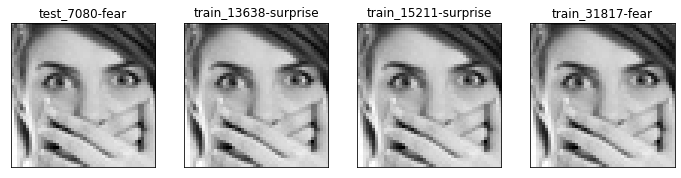

In [ ]:
num_c = unique.shape[0]-1
print(num_c)
y_db_array = []
for clusters in range(num_c):
    y_db_array.append(np.argwhere(y_db == clusters))
    
plt.rc('image', cmap='gray')
cluster = 572
fig_dim = y_db_array[cluster].shape[0]
print(fig_dim)
plt.figure(figsize=(15, fig_dim/1.3))
#start = 340
for i in range(fig_dim):
    plt.subplot(fig_dim//5+1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

Above is the cross labeled image: 2 of them are 'fear' and 2 of them are 'surprise'.  
We are going to remove such cross labeled images


##### Single labeled images

1516
7


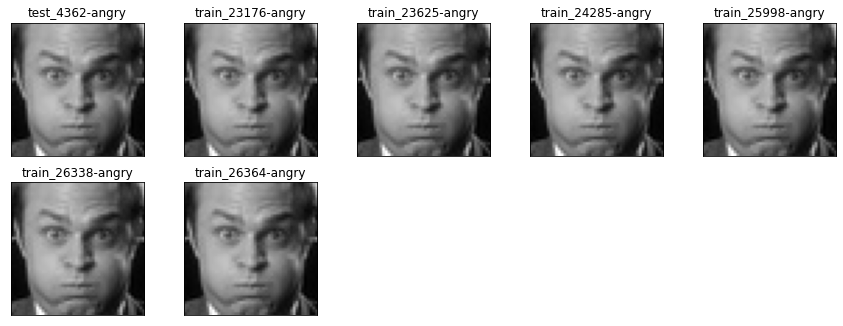

In [ ]:
num_c = unique.shape[0]-1
print(num_c)
y_db_array = []
for clusters in range(num_c):
    y_db_array.append(np.argwhere(y_db == clusters))
    
plt.rc('image', cmap='gray')
cluster = 391
fig_dim = y_db_array[cluster].shape[0]
print(fig_dim)
plt.figure(figsize=(15, fig_dim/1.3))
#start = 300
for i in range(fig_dim):
    plt.subplot(fig_dim//5+1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))


Above is the single labeled image: 7 images are all identical and they are labeled as fear.  
In this case, we are going to leave 1 images for each 'test' and 'train' set and will remove the rest.

** Finding indices for the duplicated images **

In [ ]:
dup_index = []
for i in range(len(y_db_array)):
    train = []
    test = []
    
    #print([Y[n[0]] for n in y_db_array[i]])
    #print([c_ind[0] for c_ind in y_db_array[i]])
    
    if np.unique([Y[n[0]] for n in y_db_array[i]]).shape[0] > 1: # In Cross-labeled cases, delete all
        for idx in y_db_array[i]:
            dup_index.append(idx[0])
        #print(i)
    elif np.unique([Y[n[0]] for n in y_db_array[i]]).shape[0] == 1: # In Single-labeled cases
        for idx in y_db_array[i]:     
            if 'train' in Z[idx[0]]:          # divide test and train sets
                train.append(idx[0])
            elif 'test' in Z[idx[0]]:
                test.append(idx[0])
        #print(i,'train:\t',train)
        #print(i,'test :\t',test)
        if len(train) > 1:                    # leave only 1 img for each set
            for idx in train[1:]:
                dup_index.append(idx)
        if len(test) > 1:
            for idx in test[1:]:
                dup_index.append(idx)

# Data Preprocessing

In this section of the python notebook, we will remove all non-facial images and duplicates that were identified under EDA and augment the data so the training data is the same across each class. We will also standardize and create mini train and test datasets.


## Data Filtering

From above detection for the non-facial images and the duplicated images, we will remove selected images.

In [ ]:
# Combine all the removal indices (3 category non-facial images + duplicated images)
# Remove if duplicated indices exists
removal_index = list(set(letter_FFT_idx) | set(filter_black) | set(loading_KNN_hist_idx) | set(dup_index))

In [ ]:
print(len(removal_index))
print(X.shape[0])
print("We are removing %d data out of total %d, which is %.2f%% of the data " %(len(removal_index), X.shape[0], (len(removal_index)/X.shape[0]*100)))

1454
35887
We are removing 1454 data out of total 35887, which is 4.05% of the data 


In [ ]:
## Filtering Data
## remove these selected indices of data
X_filter = np.delete(X, removal_index, 0)
Y_filter = np.delete(np.array(Y), removal_index, 0).tolist()
Z_filter = np.delete(np.array(Z), removal_index, 0).tolist()

In [ ]:
#!mkdir ./drive/MyDrive/w207/dataset2
#!mkdir ./drive/MyDrive/w207/dataset2/test
#!mkdir ./drive/MyDrive/w207/dataset2/train

In [ ]:
## writing files
for i in range(X_filter.shape[0]):
    # Save the filtered data to './Dataset2/'
    directory = "./drive/MyDrive/w207/dataset2/" + Z_filter[i].split("/")[0] + "/" + Z_filter[i].split("/")[1]
    if not os.path.exists(directory):
      os.makedirs(directory)
    cv2.imwrite("./drive/MyDrive/w207/dataset2/"+Z_filter[i], X_filter[i].reshape(48,48))
    #print("./drive/MyDrive/w207/dataset2/"+Z_filter[i])
    if Z_filter[i].split("/")[1] != Y_filter[i]: # check if mislabeled case exists
        print("fault")

## Data Augmentation

In [ ]:
## Load filtered data back and divide by each category

X_ft, Y_ft, Z_ft = load_exp('./drive/MyDrive/w207/dataset2/',1)

print(X_ft.shape)
print(len(Y_ft))
print(len(Z_ft))

# happy sets
happy_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='happy']]
print(happy_set.shape)

# sad sets
sad_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='sad']]
print(sad_set.shape)

# fear sets
fear_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='fear']]
print(fear_set.shape)

# surprise sets
surprise_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='surprise']]
print(surprise_set.shape)

# neutral sets
neutral_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='neutral']]
print(neutral_set.shape)

# angry sets
angry_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='angry']]
print(angry_set.shape)

# disgust sets
disgust_set = X_ft[[i for i, expression in enumerate(Y_ft) if expression =='disgust']]
print(disgust_set.shape)

./drive/MyDrive/w207/dataset2/train/disgust
./drive/MyDrive/w207/dataset2/train/sad
./drive/MyDrive/w207/dataset2/train/surprise
./drive/MyDrive/w207/dataset2/train/happy
./drive/MyDrive/w207/dataset2/train/angry
./drive/MyDrive/w207/dataset2/train/neutral
./drive/MyDrive/w207/dataset2/train/fear
(27377, 2304)
27377
27377
(7076, 2304)
(4711, 2304)
(3873, 2304)
(2660, 2304)
(4856, 2304)
(3823, 2304)
(378, 2304)


In [ ]:
# Check the number of data
train_dir = './drive/MyDrive/w207/dataset2/train/'
test_dir = './drive/MyDrive/w207/dataset2/test/'

row, col = 48, 48
classes = 7

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

df = pd.DataFrame()
df = train_count.append(test_count)
df.loc['total'] = df.sum()
df

,disgust,sad,surprise,happy,angry,neutral,fear
train,378,4711,2660,7076,3823,4856,3873
test,108,1233,786,1763,940,1222,1004
total,486,5944,3446,8839,4763,6078,4877


<BarContainer object of 7 artists>

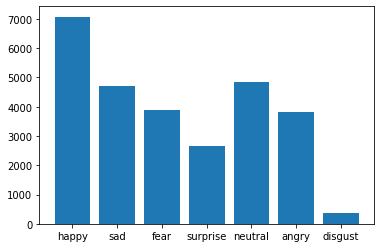

In [ ]:
x = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
val = [happy_set.shape[0], 
       sad_set.shape[0], 
       fear_set.shape[0], 
       surprise_set.shape[0], 
       neutral_set.shape[0], 
       angry_set.shape[0],
       disgust_set.shape[0]
      ]
plt.bar(x,val)

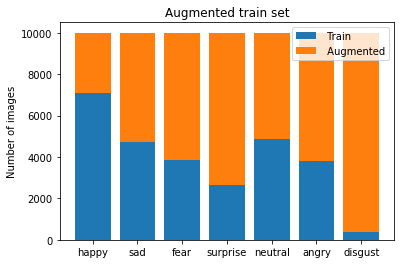

In [ ]:
fig, ax = plt.subplots()
x = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
ax.bar(x,val, label=' Train' )
ax.bar(x,[10000-i for i in val], bottom=val, label=' Augmented' )
ax.set_ylabel('Number of images')
ax.set_title('Augmented train set')
ax.legend()

In [ ]:
# Make functions to alter the images
def mirror(img):
    return cv2.flip(img, 1)


def slide(img, x=1,y=1):
    num_rows, num_cols = img.shape[:2]
    translation_matrix = np.float32([ [1,0,x], [0,1,y] ])
    return cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))


# Get a random number about 90 to 110% of the orginal value
def my_random():
    return(np.random.random() * 0.5 )+ 0.9

def warp(img):
    num_rows, num_cols = img.shape[:2]
    if np.random.random() > 0.5:
        img = mirror(img)
    translation_matrix = np.float32([ [my_random(),0,my_random()], [0,my_random(),my_random()] ])   
    return cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))


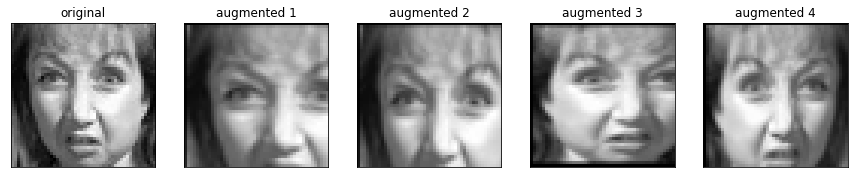

In [ ]:
## Show example of augmented images
img = X_ft[4,:]
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1,5,i+1)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('original')
        plt.imshow(img.reshape(48,48))
    else:
        ax.set_title('augmented '+str(i))
        plt.imshow(warp(img.reshape(48,48)))

In [ ]:
import random
import re
image_dim = 48

x = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

# From image_list generate num images
def generate(category , category_deficit, image_dim ,X_ft, Y_ft, Z_ft):
    augmented_images = []

    category_imgs = X_ft[np.array(Y_ft)==category,:] # select images based on labels
    
    temp_X = np.zeros((category_deficit,48*48))
    temp_Y = []
    temp_Z = []
    print(category)
    category_idxs  = np.where((np.array(Y_ft)==category) ==True)[0] # indices of the image in the original array
    #
    # generated_images = np.array[select_images , dim*dim ]
    for i in range(category_deficit): 
        src_index = random.randint(0, len(category_imgs) -1) # select an image to augment
        src_image = category_imgs[src_index,:].reshape(48,48) # it is an image

        src_file_name = Z_ft[category_idxs[src_index]]       # generate file name based on existing file name
        src_file_name = re.sub(r'\.jpg$', '_' +str(i) +'.jpg', src_file_name) 


        generated_image = warp(src_image) # so it is just a long array
#         print('generated_img.shape',generated_image.shape)
#         print(type(generated_image))
        temp_X[i,:] = generated_image.flatten()
        temp_Y.append(category)
        temp_Z.append(src_file_name)

    return temp_X, temp_Y, temp_Z
        


        
deficit = [0,0,0,0,0,0,0]

SAMPLES_PER_CLASS = 10000
for i,f in enumerate(x):
    deficit[i] =  max(SAMPLES_PER_CLASS -val[i],0) # don't want a negative number

    X_aug,Y_aug,Z_aug = generate(x[i],deficit[i], image_dim, X_ft, Y_ft, Z_ft) # hard coded image size
    X_ft = np.vstack((X_ft,X_aug))
    print(i,X_ft.shape)
    #Y_ft.append(Y_aug)
    Y_ft.extend(Y_aug)
    print(i,len(Y_ft))
    Z_ft.extend(Z_aug)

# Calculate what how many more examples do we need

happy
0 (30301, 2304)
0 30301
sad
1 (35590, 2304)
1 35590
fear
2 (41717, 2304)
2 41717
surprise
3 (49057, 2304)
3 49057
neutral
4 (54201, 2304)
4 54201
angry
5 (60378, 2304)
5 60378
disgust
6 (70000, 2304)
6 70000


In [ ]:
# Check if whoe dataset became 70000 (10000 for each category)
print(X_ft.shape)
print(len(Y_ft))
print(len(Z_ft))

(70000, 2304)
70000
70000


In [ ]:
## writing files

for i in range(X_ft.shape[0]):
    # Save the augmented data to './Dataset3/'
    cv2.imwrite("./drive/MyDrive/w207/dataset3/"+Z_ft[i], X_ft[i].reshape(48,48))
    if Z_ft[i].split("/")[1] != Y_ft[i]: # check if mislabeled case exists
        print("fault")



Shuffle images in each dataset and reshape to one dimension

In [ ]:
# Convert train and test dataset to np arrays
x_train1 = np.array(x_train)
x_test1 = np.array(x_test)
y_train1 = np.array(y_train)
y_test1 = np.array(y_test)

# Shuffle images in datasets
shuffle = np.random.permutation(np.arange(x_train1.shape[0]))
x_train1, y_train1 = x_train1[shuffle], y_train1[shuffle]

shuffle = np.random.permutation(np.arange(x_test1.shape[0]))
x_test1, y_test1 = x_test1[shuffle], y_test1[shuffle]

# reshape images to 1 dimension
nsamples, nx, ny = x_train1.shape
x_train1 = x_train1.reshape((nsamples,nx*ny))

nsamples, nx, ny = x_test1.shape
x_test1 = x_test1.reshape((nsamples,nx*ny))

##Feature Scaling

Rescale grayscale values

In [ ]:
x_train = np.array(x_train1)
y_train = np.array(y_train1)

x_test = np.array(x_test1)
y_test = np.array(y_test1)

# Rescale grayscale values to [0,1].
x_train = x_train / 255.0
x_test = x_test / 255.0

# set temporary lists to null and release RAM
x_train1=[]
x_test1=[]
y_train1=[]
y_test1=[]

###Standardize and create mini datasets

In [ ]:
# Create mini train dataset
x_mini_train= x_train[:1000]
y_mini_train= y_train[:1000]

x_mini_test = x_test[:200]
y_mini_test = y_test[:200]

# Use Robustscaler to standardize data
rc = RobustScaler()

# Estimate the sample mean and standard deviation for each feature in x_train
rc.fit(x_train)

# use the two parameters to standardize both train and test data
x_train_std = rc.transform(x_train)
x_test_std = rc.transform(x_test)

# Estimate the sample mean and standard deviation for each feature in x_mini_train
rc.fit(x_mini_train)

# use the two parameters to standardize both mini train_data and test_data
x_mini_train_std = rc.transform(x_mini_train)
x_mini_test_std = rc.transform(x_mini_test)

#Blurring Techniques - Gaussian Blur

Apply a gaussian 3x3 kernel to each neighboring pixel value to derive the new pixel value. Ignore 5 border pixels in the image since emotion is unlikely to be represented in the borders of the image.


In [ ]:
def gaussian_blur(dataset, weight):    
    '''
    In this version of Advanced Gaussian Blur, we do not process the border pixels in the image.
    It is unlikely the the image extends all the way to the borders. 
    The previous version assumes zero values for NN that are out of the bounds of the image boundaries.
    we use values from a 3x3 kernel and apply it 
    to the NNs. We then apply the weight to derive the new value of the pixel.
    '''

    f_weight = float(weight)

    image_blur_dataset=[]
    # data is 784, convert to 28x28 pixels    
    #algorithm

    for image in dataset:
        image = image.reshape(48,48)
        image_blur=np.zeros((48,48))

        for x in range(5,44):
            row = image[x]
            # get 8 NN for each pixel
            e_f=w_f=n_f=s_f=nw_f=sw_f=ne_f=se_f=0
            e_n=w_n=n_n=s_n=nw_n=sw_n=ne_n=se_n=0

            for y in range(5,44):
                pix = row[y]
                kernel=[]

                # identify NNs                
                e_n=image[x][y+1]                
                w_n=image[x][y-1] 
                n_n=image[x-1][y]
                s_n=image[x+1][y]
                nw_n=image[x-1][y-1]        
                sw_n=image[x+1][y-1]               
                ne_n=image[x-1][y+1]                   
                se_n=image[x+1][y+1] 

                gaussian_array = np.array([nw_n, n_n, ne_n, w_n, pix, e_n, sw_n, s_n, se_n])

                # define kernel
                kernel=np.array([1,2,1,2,4,2,1,2,1])

                new_pix=0;
                temp_pix_val=0;
                for i in range(9):
                    temp_pix_val = gaussian_array[i]*kernel[i]
                    new_pix = new_pix + temp_pix_val

                new_pix = f_weight * new_pix/16
                image_blur[x][y]=float(new_pix)

        image_blur_dataset.append(image_blur)

    temp_lst=np.array(image_blur_dataset)
    rows, length, cols=temp_lst.shape
    image_blur_dataset_reshaped=temp_lst.reshape((rows, length*cols))
    return image_blur_dataset_reshaped

##Blurred Datasets

Create blurred datasets using the UDF above and pass different weights to generate each dataset. Create blurred images for both training and test datasets using standardized images (using Robustscaler). 
Note: Multinomial NB does not work well with standardized data, therefore original image data was used to generate blurred train and text images

In [ ]:
weight_arr=[0.25, 0.5, 0.75]
print('Applying Gaussian Blur')

for t_weight in weight_arr:
    print("Weight=", t_weight)
    if t_weight == 0.25:
        x_train_blur_25=gaussian_blur(x_train_std, t_weight)
        x_test_blur_25=gaussian_blur(x_test_std, t_weight)

        x_mini_train_blur_25=gaussian_blur(x_mini_train_std, t_weight)
        x_mini_train_blur_25_m=gaussian_blur(x_mini_train, t_weight)
        
        # Multinomial NB does. not work on standardized data. Use original dataset to create blurred datasets
        x_train_blur_25_m=gaussian_blur(x_train, t_weight)
        x_mini_train_blur_25_m=gaussian_blur(x_mini_train, t_weight)

        x_test_blur_25_m=gaussian_blur(x_test, t_weight)
        x_mini_test_blur_25_m=gaussian_blur(x_mini_test, t_weight)

    elif t_weight == 0.50:
        x_train_blur_50=gaussian_blur(x_train_std, t_weight)
        x_test_blur_50=gaussian_blur(x_test_std, t_weight)

        x_mini_train_blur_50=gaussian_blur(x_mini_train_std, t_weight)
        x_mini_train_blur_50_m=gaussian_blur(x_mini_train, t_weight)

        # Multinomial NB does. not work on standardized data. Use original dataset to create blurred datasets
        x_train_blur_50_m=gaussian_blur(x_train, t_weight)
        x_mini_train_blur_50_m=gaussian_blur(x_mini_train, t_weight)

        x_test_blur_50_m=gaussian_blur(x_test, t_weight)
        x_mini_test_blur_50_m=gaussian_blur(x_mini_test, t_weight)

    elif t_weight == 0.75:
        x_train_blur_75=gaussian_blur(x_train_std, t_weight)
        x_test_blur_75=gaussian_blur(x_test_std, t_weight)

        x_mini_train_blur_75=gaussian_blur(x_mini_train_std, t_weight)
        x_mini_train_blur_75_m=gaussian_blur(x_mini_train, t_weight)

        # Multinomial NB does. not work on standardized data. Use original dataset to create blurred datasets
         x_train_blur_75_m=gaussian_blur(x_train, t_weight)
        x_mini_train_blur_75_m=gaussian_blur(x_mini_train, t_weight)

        x_test_blur_75_m=gaussian_blur(x_test, t_weight)
        x_mini_test_blur_75_m=gaussian_blur(x_mini_test, t_weight)


#Model Building




##Model 1: K-Nearest Neighbor

It's also called a lazy learner because it doesn't learn any discriminative function from the training data, but memorizes the data instead.

In [ ]:
# initialize pandas dataframe to store model results
knn_df = pd.DataFrame()

### K-Nearest Neighbor (Baseline) - Blur

Using blurred dataset created above, we will implement KNN choosing 5 for the number of k (neighbors) and a default distance metric.  



In [ ]:
## Baseline KNN performance using k=5 and blurred data

for t_weight in weight_arr:
    print('Weight=', t_weight)
    score=0.0
    y_pred=0

    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    if t_weight == 0.25:
        knn.fit(x_train_blur_25, y_train)
        y_pred=knn.predict(x_test_blur_25)
        score=knn.score(x_test_blur_25,y_test)

    elif t_weight == 0.50:
        knn.fit(x_train_blur_50, y_train)
        y_pred=knn.predict(x_test_blur_50)
        score=knn.score(x_test_blur_50,y_test)

    elif t_weight == 0.75:
        knn.fit(x_train_blur_75, y_train)
        y_pred=knn.predict(x_test_blur_75)
        score=knn.score(x_test_blur_75,y_test)

    print('KNN: Score is %.3f' %score)
    accuracy=accuracy_score(y_test, y_pred)
    print('KNN: Accuracy score is %.3f' %accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('KNN: f1_score: %.3f' % f1)

    data = [["KNN", "Default", 5, "Yes", t_weight, score, accuracy, f1] ]
 
    # store the results into the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "neighbors", "blurring", "weight", "score", "accuracy", "f1_score"])
    knn_df = knn_df.append(df, ignore_index=True)

###Hyperparameters (Blur)

Using blurred mini train dataset, we will attempt to identify the optimal hyperparameters for KNN using GridSearchCV

##### n_neighbors: Number of neighbors to use for model
##### leaf_size: leaf_size passed to BallTree or KDTree
##### p: power parameter for Minkowski metric
##### algorithm: alogorithm to use to compute KNN
##### weights: weight function used in prediction


In [ ]:
## identifying hyperparameters for KNN using blurred dataset

leaf_size = list(range(1,40, 2))
n_neighbors = list(range(1,40,2))
p = [1,2] # p=1 (Manhattan distance) and p=2 (Euclidean)
n_jobs=[-1]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights, n_jobs=n_jobs )

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch to identify best model
clf = GridSearchCV(knn, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model on mini train dataset
best_model = clf.fit(x_mini_train_blur_25,y_mini_train)

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])

###K-Nearest Neighbor (Hypertuned) - Blur

Using optimal hyperparameters identified above, run KNN using the full train and test datasets

In [ ]:
# Use hyperparameters identified above to run optimal KNN model

leaf_size = best_model.best_estimator_.get_params()['leaf_size']
p = best_model.best_estimator_.get_params()['p']
n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
algorithm = best_model.best_estimator_.get_params()['algorithm']
weights = best_model.best_estimator_.get_params()['weights']

print(leaf_size, p, n_neighbors, algorithm, weights)

# KNeighborsClassifier to produce a k-nearest neighbor model.
knn = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights, n_jobs=-1)

# Train on standardized mini_train_data
knn.fit(x_train_blur_25, y_train)

# evaluate performance on standardized dev_data
y_pred = knn.predict(x_test_blur_25)
score = knn.score(x_test_blur_25, y_test)

print('KNN: Score: %.3f' % score)
accuracy = accuracy_score(y_test, y_pred)

print('KNN: Accuracy: %.3f' % accuracy)
f1 = f1_score(y_test, y_pred, average='weighted')

print('KNN: f1_score: %.3f' % f1)
data = [["KNN", "Hyperparameters", n_neighbors, "Yes", score, accuracy, f1, leaf_size,p, algorithm,weights  ] ]

# store results in pandas dataframe
df = pd.DataFrame(data, columns = ["model", "type", "neighbors", "blurring", "score", "accuracy", "f1_score", "leaf_size", "p", "algorithm", "weights"])
knn_df = knn_df.append(df, ignore_index=True)

# write dataframe to csv file for futher analysis
knn_df.to_csv("/content/drive/MyDrive/w207/KNN-Blur-Std.csv", sep='\t', encoding='utf-8')
knn_df = pd.DataFrame()


In [ ]:
# read output file created by KNN model
my_df = pd.read_csv("/content/drive/MyDrive/w207/KNN-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,neighbors,blurring,weight,score,accuracy,f1_score,leaf_size,p,algorithm,weights
0,0,KNN,Default,5,Yes,0.25,0.341837,0.341837,0.349465,,,,
1,1,KNN,Default,5,Yes,0.5,0.341837,0.341837,0.349465,,,,
2,2,KNN,Default,5,Yes,0.75,0.341837,0.341837,0.349465,,,,
3,3,KNN,Hyperparameters,11,Yes,,0.327239,0.327239,0.332428,1,2,auto,uniform


###K-Nearest Neighbor (Standard) - Baseline

Using standardized dataset created above, we will implement KNN choosing 5 for the number of k (neighbors) and a default distance metric.

In [ ]:
## Baseline KNN model using standardized data
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Train on standardized train_data
knn.fit(x_train_std, y_train)
# evaluate performance on standardized test_data

y_pred = knn.predict(x_test_std)

score = knn.score(x_test_std, y_test)

print(‘KNN: Score: %.3f’ % score)
accuracy = accuracy_score(y_test, y_pred)

print(‘KNN: Accuracy: %.3f’ % accuracy)
f1 = f1_score(y_test, y_pred, average=‘weighted’)

print(‘KNN: f1_score: %.3f’ % f1)
data = [[“KNN”, “Default”, 5, “No”, score, accuracy, f1] ]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = [“model”, “type”, “neighbors”, “blurring”, “score”, “accuracy”, “f1_score”])

knn_df = knn_df.append(df, ignore_index=True)

###Hyperparameters (Standard)

Using standard mini train dataset, we will attempt to identify the optimal hyperparameters for KNN using GridSearchCV

##### n_neighbors: Number of neighbors to use for model
##### leaf_size: leaf_size passed to BallTree or KDTree
##### p: power parameter for Minkowski metric
##### algorithm: alogorithm to use to compute KNN
##### weights: weight function used in prediction

In [ ]:
# Identify Hyperparameters for KNN using standardized mini_train_data

leaf_size = list(range(1,40, 2))
n_neighbors = list(range(1,40,2))
p = [1,2] # p=1 (Manhattan distance) and p=2 (Euclidean)
n_jobs=[-1]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights, n_jobs=n_jobs )

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch to identify best hyperparameters
clf = GridSearchCV(knn, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])

###K-Nearest Neighbor (Hypertuned) - Standard, No Blur

Using optimal hyperparameters identified above, run KNN using the full train and test datasets

In [ ]:
# Use hyperparameters identified above to run optimal KNN model

leaf_size = best_model.best_estimator_.get_params()['leaf_size']
p = best_model.best_estimator_.get_params()['p']
n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
algorithm = best_model.best_estimator_.get_params()['algorithm']
weights = best_model.best_estimator_.get_params()['weights']

print(leaf_size, p, n_neighbors, algorithm, weights)

# KNeighborsClassifier to produce a k-nearest neighbor model.
knn = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights, n_jobs=-1)

# Train on standardized mini_train_data
knn.fit(x_train_std, y_train)
# evaluate performance on standardized dev_data
y_pred = knn.predict(x_test_std)

score = knn.score(x_test_std, y_test)
print('KNN: Score: %.3f' % score)

accuracy = accuracy_score(y_test, y_pred)
print('KNN: Accuracy: %.3f' % accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('KNN: f1_score: %.3f' % f1)

data = [["KNN", "Hyperparameters", n_neighbors, "No", score, accuracy, f1, leaf_size,p, algorithm,weights  ] ]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "neighbors", "blurring", "score", "accuracy", "f1_score", "leaf_size", "p", "algorithm", "weights"])
knn_df = knn_df.append(df, ignore_index=True)

# write results to csv file
knn_df.to_csv("/content/drive/MyDrive/w207/KNN-NoBlur-Std.csv", sep='\t', encoding='utf-8')
knn_df = pd.DataFrame()

In [ ]:
# read output file created by KNN model
my_df = pd.read_csv("/content/drive/MyDrive/w207/KNN-NoBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,neighbors,blurring,score,accuracy,f1_score,leaf_size,p,algorithm,weights
0,0,KNN,Default,5,No,0.336168,0.336168,0.334359,,,,
1,1,KNN,Hyperparameters,29,No,0.314626,0.314626,0.290286,1,2,auto,uniform


##Model 2: Decision Tree

Is used for classifying non-linearly separable data. Based on the features of the training set, the decission tree classifier learns a series of questions to infer the class labels.
We start at the tree root (contains all data) and split the data on the feature that results in the largest Information Gain (IG). Using an iterative process, the splitting procedure at each child node is repeated until the leaf node is reached.

###No Blur

#### Decision Tree - Baseline
Using standardized dataset created above, we will implement Decision Tree model using default hyperparameters.

In [ ]:
#Initialize dafarame to store results from model
dt_base_df = pd.DataFrame()

In [ ]:
# Note: Default criterion is gini
tree = DecisionTreeClassifier(criterion='gini')

tree = tree.fit(x_train_std, y_train)

y_train_pred = tree.predict(x_train_std)
y_test_pred = tree.predict(x_test_std)

train_score = tree.score(x_train_std, y_train_pred)
test_score = tree.score(x_test_std, y_test_pred)
print('Decision tree train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('Decision tree train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))


data = [["DT", "Default", "No", "Train", "Yes", a_tree_train, f_tree_train, train_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
dt_base_df = dt_base_df.append(df, ignore_index=True)

data = [["DT", "Default", "No", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# save results to pandas dataframe
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
dt_base_df = dt_base_df.append(df, ignore_index=True)


####Adaboost - Baseline
Using standardized dataset created above, we will implement Adaboost ensemble model using default hyperparameters.

In [ ]:
# Create dataframe to store model results
ad_base_df = pd.DataFrame()

In [ ]:
# pass a refrence to the Decision Tree classifier
ada = AdaBoostClassifier(base_estimator=tree)

ada = ada.fit(x_train_std, y_train)
y_train_pred = ada.predict(x_train_std)
y_test_pred = ada.predict(x_test_std)

train_score = ada.score(x_train_std, y_train_pred)
test_score = ada.score(x_test_std, y_test_pred)
print('AdaBoost train/test score %.3f/%.3f'
      % (train_score, test_score))

f_ada_train = f1_score(y_train, y_train_pred, average='weighted')
f_ada_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoost train/test f1_score %.3f/%.3f'
      % (f_ada_train, f_ada_test))

a_ada_train = accuracy_score(y_train, y_train_pred)
a_ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (a_ada_train, a_ada_test))

data = [["Adaboost", "Default", "No", "Train", "Yes", a_ada_train, f_ada_train, train_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
ad_base_df = ad_base_df.append(df, ignore_index=True)

data = [["Adaboost", "Default", "No", "Test", "Yes", a_ada_test, f_ada_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])

# save results to the pandas dataframe
ad_base_df = ad_base_df.append(df, ignore_index=True)


####Bagging - Baseline

Using standardized dataset created above, we will implement Bagging ensemble model using default hyperparameters.

In [ ]:
# Create dataframe to store results from
bg_base_df = pd.DataFrame()

In [ ]:
# Pass a reference to the Decision Tree model
bag = BaggingClassifier(base_estimator=tree)

bag = bag.fit(x_train_std, y_train)
y_train_pred = bag.predict(x_train_std)
y_test_pred = bag.predict(x_test_std)

train_score = bag.score(x_train_std, y_train_pred)
test_score = bag.score(x_test_std, y_test_pred)
print('BaggingClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_bag_train = f1_score(y_train, y_train_pred, average='weighted')
f_bag_test = f1_score(y_test, y_test_pred, average='weighted')
print('BaggingClassifier train/test f1_score %.3f/%.3f'
      % (f_bag_train, f_bag_test))

a_bag_train = accuracy_score(y_train, y_train_pred)
a_bag_test = accuracy_score(y_test, y_test_pred)
print('BaggingClassifier train/test accuracies %.3f/%.3f'
      % (a_bag_train, a_bag_test))


data = [["Bagging", "Default", "No", "Train", "Yes", a_bag_train, f_bag_train, train_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
bg_base_df = bg_base_df.append(df, ignore_index=True)

data = [["Bagging", "Default", "No", "Test", "Yes", a_bag_test, f_bag_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])

#Save model results to dataframe
bg_base_df = bg_base_df.append(df, ignore_index=True)

####Decision Tree - Hyperparameters

Below are the hyperparameters that were consider for tuning the Decision Tree model. We used GridSearchCV to identify the optimal hyperparameters.

##### criterion: Function to measute the quality of the split
##### splitter: Strategy to choose the split at each node
##### max_depth: Maximum depth of the tree
##### min_samples_split: Number of samples used to split an internal node
##### min_samples_leaf: Number of samples required to be at the leaf node
##### min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
##### max_features: The number of features to consider when looking for the best split:
##### random_state: Controls the randomness of the estimator
##### max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion
##### min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than this value
##### class_weight : Weights associated with classes
##### ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning

In [ ]:
# identify hyperparameters for Decision Tree model
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [5, 6, None]
min_samples_split = [3,2]
min_samples_leaf = [2,1]
min_weight_fraction_leaf = [0, 0.5, 1.0]
max_features = ['auto', 'sqrt', 'log2', None]
random_state = [1, None]
max_leaf_nodes = [2, None]
min_impurity_decrease = [1.0, 0.0]
class_weight = ['balanced', None]
ccp_alpha = [1.0, 0.0]

hyperparameters = dict(criterion=criterion,splitter=splitter,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, \
                       min_weight_fraction_leaf=min_weight_fraction_leaf,max_features=max_features,random_state=random_state, \
                       max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=min_impurity_decrease, \
                       class_weight=class_weight,ccp_alpha=ccp_alpha)

#Create new KNN object
DT = DecisionTreeClassifier()
#Use GridSearch
clf = GridSearchCV(DT, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train,y_mini_train)

#Print The value of best Hyperparameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion']) 
print('Best splitter:', best_model.best_estimator_.get_params()['splitter']) 
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth']) 
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split']) 
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf']) 
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf']) 
print('Best max_features:', best_model.best_estimator_.get_params()['max_features']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state']) 
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes']) 
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease']) 
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight']) 
print('Best ccp_alpha:', best_model.best_estimator_.get_params()['ccp_alpha'])

#### Decision Tree - Hypertuned
run model with hyperparameters




In [ ]:
# Create dataframe to store model results
dt_hyper_df = pd.DataFrame()

In [ ]:
# Run model with optimal hyperparameters
criterion = best_model.best_estimator_.get_params()['criterion']
splitter = best_model.best_estimator_.get_params()['splitter']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_samples_split = best_model.best_estimator_.get_params()['min_samples_split']
min_samples_leaf = best_model.best_estimator_.get_params()['min_samples_leaf']
min_weight_fraction_leaf = best_model.best_estimator_.get_params()['min_weight_fraction_leaf']
max_features = best_model.best_estimator_.get_params()['max_features'] 
random_state = best_model.best_estimator_.get_params()['random_state']
max_leaf_nodes = best_model.best_estimator_.get_params()['max_leaf_nodes']
min_impurity_decrease = best_model.best_estimator_.get_params()['min_impurity_decrease'] 
class_weight = best_model.best_estimator_.get_params()['class_weight'] 
ccp_alpha = best_model.best_estimator_.get_params()['ccp_alpha']


print('criterion:', criterion)
print('splitter:', splitter)
print('max_depth:', max_depth)
print('min_samples_split:',  min_samples_split)
print('min_samples_leaf:', min_samples_leaf)
print('min_weight_fraction_leaf: ',min_weight_fraction_leaf)
print('max_features:',max_features)
print('random_state:',random_state)
print('max_leaf_nodes:',max_leaf_nodes)
print('min_impurity_decrease:',min_impurity_decrease)
print('class_weight:',class_weight)
print('ccp_alpha:',ccp_alpha)

tree = DecisionTreeClassifier(criterion=criterion,splitter=splitter,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, \
                       min_weight_fraction_leaf=min_weight_fraction_leaf,max_features=max_features,random_state=random_state, \
                       max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=min_impurity_decrease, \
                       class_weight=class_weight,ccp_alpha=ccp_alpha)

tree = tree.fit(x_train_std, y_train)

y_train_pred = tree.predict(x_train_std)
y_test_pred = tree.predict(x_test)

train_score = tree.score(x_train_std, y_train_pred)
test_score = tree.score(x_test_std, y_test_pred)
print('Decision tree train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('Decision tree train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))


data = [["DT", "Hyperparameters", "No", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["criterion"] = criterion
df["splitter"] = splitter
df["max_depth"] = max_depth
df["min_samples_split"] = min_samples_split
df["min_samples_leaf"] = min_samples_leaf
df["min_weight_fraction_leaf"]=min_weight_fraction_leaf
df["max_features"]=max_features
df["random_state"]=random_state
df["max_leaf_nodes"] = max_leaf_nodes
df["min_impurity_decrease"] = min_impurity_decrease
df["class_weight"] = class_weight
df["ccp_alpha"] = ccp_alpha

dt_hyper_df = dt_hyper_df.append(df, ignore_index=True)

data = [["DT", "Hyperparameters", "No", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["criterion"] = criterion
df["splitter"] = splitter
df["max_depth"] = max_depth
df["min_samples_split"] = min_samples_split
df["min_samples_leaf"] = min_samples_leaf
df["min_weight_fraction_leaf"]=min_weight_fraction_leaf
df["max_features"]=max_features
df["random_state"]=random_state
df["max_leaf_nodes"] = max_leaf_nodes
df["min_impurity_decrease"] = min_impurity_decrease
df["class_weight"] = class_weight
df["ccp_alpha"] = ccp_alpha

# save results into pandas dataframe
dt_hyper_df = dt_hyper_df.append(df, ignore_index=True)


#### Adaboost - Hyperparameters

Below are the hyperparameters that were consider for tuning the Adaboost ensemble model. We used GridSearchCV to identify the optimal hyperparameters.

##### n_estimators: The maximum number of estimators at which boosting is terminated
##### algorithm: algorithm to use to run model
##### random_state: Controls the random seed given at each base_estimator

In [ ]:
#base_estimator = [None, 1,2]
n_estimators = [100,500,800]
algorithm = ['SAMME', 'SAMME.R']
random_state = [1, None]

hyperparameters = dict(n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

# Create new KNN object
AD = AdaBoostClassifier()
# Use GridSearch
clf = GridSearchCV(AD, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best base_estimator:', best_model.best_estimator_.get_params()['base_estimator']) 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators']) 
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state'])  

####Adaboost - Hypertuned
Run model using optimal hyperparameters



In [ ]:
# Create dataframe to save model results
ad_hyper_df = pd.DataFrame()

In [ ]:
# run model with optimal hyperparameters
base_estimator = best_model.best_estimator_.get_params()['base_estimator']
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
algorithm = best_model.best_estimator_.get_params()['algorithm']
random_state = best_model.best_estimator_.get_params()['random_state']  
print(base_estimator, n_estimators, algorithm, random_state )

ada = AdaBoostClassifier(base_estimator=tree,n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

ada = ada.fit(x_train_std, y_train)
y_train_pred = ada.predict(x_train_std)
y_test_pred = ada.predict(x_test_std)

train_score = ada.score(x_train_std, y_train_pred)
test_score = ada.score(x_test_std, y_test_pred)
print('AdaBoostClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoostClassifier train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('AdaBoostClassifier train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["Adaboost", "Hyperparameters", "No", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_hyper_df = ad_hyper_df.append(df, ignore_index=True)

data = [["Adaboost", "Hyperparameters", "No", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_hyper_df = ad_hyper_df.append(df, ignore_index=True)

# save results to csv file
ad_hyper_df.to_csv("/content/drive/MyDrive/w207/Adaboost_hyperparameters_NoBlur.csv", sep='\t', encoding='utf-8')


In [ ]:
# read output file created by Adaboost Ensemble model
ad_hyper_df = pd.read_csv("/content/drive/MyDrive/w207/Adaboost_hyperparameters_NoBlur.csv", sep='\t')
ad_hyper_df = ad_hyper_df.fillna('')
ad_hyper_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,base_estimator,n_estimators,algorithm,random_state
0,0,Adaboost,Hyperparameters,No,Train,Yes,0.359786,0.354444,1.0,,100,SAMME,1
1,1,Adaboost,Hyperparameters,No,Test,Yes,0.334609,0.324612,1.0,,100,SAMME,1


#### Bagging - Hyperparameters

Below are the hyperparameters that were consider for tuning the Bagging ensemble model. We used GridSearchCV to identify the optimal hyperparameters.

##### n_estimators: The number of base estimators in the ensemble.
##### warm_start: reuse the solution of the previous call to fit and add more estimators to the ensemble
##### bootstrap_features: Whether features are drawn with replacement.
##### bootstrap: Whether samples are drawn with replacement
##### random_state: Controls the random resampling of the original dataset

In [ ]:
#base_estimator = [None, 1,2]
n_estimators = [100,500,800]
warm_start =[True, False]
bootstrap_features = [True, False]
bootstrap=[True, False]
random_state = [1, None]
#n_jobs = [-1]

hyperparameters = dict(n_estimators=n_estimators,warm_start=warm_start,random_state=random_state,bootstrap_features=bootstrap_features,bootstrap=bootstrap)

#Create new KNN object
BC = BaggingClassifier()
#Use GridSearch
clf = GridSearchCV(BC, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best base_estimator:', best_model.best_estimator_.get_params()['base_estimator']) 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators']) 
print('Best warm_start:', best_model.best_estimator_.get_params()['warm_start']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state'])  
print('Best bootstrap_features:', best_model.best_estimator_.get_params()['bootstrap_features'])  
print('Best bootstrap:', best_model.best_estimator_.get_params()['bootstrap']) 

#### Bagging - Hypertuned

Run model using optimal hyperparameters

In [ ]:
# create dataframe to store results from model
bg_hyper_df = pd.DataFrame()

In [ ]:
#base_estimator = best_model.best_estimator_.get_params()['base_estimator']

n_estimators = best_model.best_estimator_.get_params()['n_estimators']
warm_start = best_model.best_estimator_.get_params()['warm_start']
random_state = best_model.best_estimator_.get_params()['random_state']
bootstrap_features = best_model.best_estimator_.get_params()['bootstrap_features'] 
bootstrap = best_model.best_estimator_.get_params()['bootstrap']

print(n_estimators, warm_start, bootstrap_features, bootstrap, random_state )
bag = BaggingClassifier(base_estimator=tree,n_estimators=n_estimators,warm_start=warm_start,random_state=random_state,bootstrap_features=bootstrap_features,bootstrap=bootstrap, n_jobs=1)

bag = bag.fit(x_mini_train_std, y_mini_train)
y_train_pred = bag.predict(x_mini_train_std)
y_test_pred = bag.predict(x_mini_test_std)

train_score = bag.score(x_mini_train_std, y_train_pred)
test_score = bag.score(x_mini_test_std, y_test_pred)
print('BaggingClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_mini_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_mini_test, y_test_pred, average='weighted')
print('BaggingClassifier train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_mini_train, y_train_pred)
a_tree_test = accuracy_score(y_mini_test, y_test_pred)
print('BaggingClassifier train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["Bagging", "Hyperparameters", "No", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["n_estimators"] = n_estimators
df["warm_start"] = warm_start
df["random_state"] = random_state
df["bootstrap_features"] = bootstrap_features
df["bootstrap"] = bootstrap

bg_hyper_df = bg_hyper_df.append(df, ignore_index=True)

data = [["Bagging", "Hyperparameters", "No", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["n_estimators"] = n_estimators
df["warm_start"] = warm_start
df["random_state"] = random_state
df["bootstrap_features"] = bootstrap_features
df["bootstrap"] = bootstrap

bg_hyper_df = bg_hyper_df.append(df, ignore_index=True)

bg_hyper_df.to_csv("/content/drive/MyDrive/w207/Bagging_hyperparameters_NoBlur.csv", sep='\t', encoding='utf-8')

In [ ]:
# read output file created by Bagging Ensemble model
bg_hyper_df = pd.read_csv("/content/drive/MyDrive/w207/Bagging_hyperparameters_NoBlur.csv", sep='\t')
bg_hyper_df = bg_hyper_df.fillna('')
bg_hyper_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,n_estimators,warm_start,random_state,bootstrap_features,bootstrap
0,0,Bagging,Hyperparameters,No,Train,Yes,1.000,1.000,1.0,500,True,None,True,True
1,1,Bagging,Hyperparameters,No,Test,Yes,0.388,0.389,1.0,500,True,None,True,True


In [ ]:
base_estimator = best_model.best_estimator_.get_params()['base_estimator']
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
algorithm = best_model.best_estimator_.get_params()['algorithm']
random_state = best_model.best_estimator_.get_params()['random_state']  
print(base_estimator, n_estimators, algorithm, random_state )

ada = AdaBoostClassifier(base_estimator=tree,n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

ada = ada.fit(x_train_std, y_train)
y_train_pred = ada.predict(x_train_std)
y_test_pred = ada.predict(x_test_std)

train_score = ada.score(x_train_std, y_train_pred)
test_score = ada.score(x_test_std, y_test_pred)
print('AdaBoostClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoostClassifier train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('AdaBoostClassifier train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["Adaboost", "Hyperparameters", "No", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_base_df = ad_base_df.append(df, ignore_index=True)

data = [["Adaboost", "Hyperparameters", "No", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_base_df = ad_base_df.append(df, ignore_index=True)


###Blur

In [ ]:
weight_arr=[0.25, 0.5, 0.75]
print('Applying Gaussian Blur')

for t_weight in weight_arr:
    print('Weight=', t_weight)
    x_train_blur=gaussian_blur(x_train_std, t_weight)
    x_test_blur=gaussian_blur(x_test_std, t_weight)

    tree = DecisionTreeClassifier(criterion='gini')

    tree = tree.fit(x_train_blur, y_train)

    y_train_pred = tree.predict(x_train_blur)
    y_test_pred = tree.predict(x_test_blur)

    train_score = tree.score(x_train_blur, y_train_pred)
    test_score = tree.score(x_test_blur, y_test_pred)
    print('Decision tree train/test score %.3f/%.3f'
          % (train_score, test_score))

    f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
    f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
    print('Decision tree train/test f1_score %.3f/%.3f'
          % (f_tree_train, f_tree_test))

    a_tree_train = accuracy_score(y_train, y_train_pred)
    a_tree_test = accuracy_score(y_test, y_test_pred)
    print('Decision tree train/test accuracies %.3f/%.3f'
          % (a_tree_train, a_tree_test))

#### Decision Tree - Baseline

Using Blurred dataset created above, we will implement Decision Tree model using default hyperparameters.


In [ ]:
for t_weight in weight_arr:
    print('Weight=', t_weight)
    y_train_pred=0
    y_test_pred=0
    f_tree_train = 0
    f_tree_test = 0
    a_tree_train = 0
    a_tree_test = 0

    tree = DecisionTreeClassifier(criterion='gini')
    if t_weight == 0.25:
        tree = tree.fit(x_train_blur_25, y_train)

        y_train_pred = tree.predict(x_train_blur_25)
        y_test_pred = tree.predict(x_test_blur_25)

        train_score = tree.score(x_train_blur_25, y_train_pred)
        test_score = tree.score(x_test_blur_25, y_test_pred)
        print('Decision tree train/test score %.3f/%.3f'
              % (train_score, test_score))

    elif t_weight == 0.50:
        tree = tree.fit(x_train_blur_50, y_train)

        y_train_pred = tree.predict(x_train_blur_50)
        y_test_pred = tree.predict(x_test_blur_50)

        train_score = tree.score(x_train_blur_50, y_train_pred)
        test_score = tree.score(x_test_blur_50, y_test_pred)
        print('Decision tree train/test score %.3f/%.3f'
              % (train_score, test_score))

    elif t_weight == 0.75:
        tree = tree.fit(x_train_blur_75, y_train)

        y_train_pred = tree.predict(x_train_blur_75)
        y_test_pred = tree.predict(x_test_blur_75)

        train_score = tree.score(x_train_blur_75, y_train_pred)
        test_score = tree.score(x_test_blur_75, y_test_pred)
        print('Decision tree train/test score %.3f/%.3f'
              % (train_score, test_score))

    f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
    f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
    print('Decision tree train/test f1_score %.3f/%.3f'
          % (f_tree_train, f_tree_test))

    a_tree_train = accuracy_score(y_train, y_train_pred)
    a_tree_test = accuracy_score(y_test, y_test_pred)
    print('Decision tree train/test accuracies %.3f/%.3f'
          % (a_tree_train, a_tree_test))

    data = [["DT", "Default", "Yes", "Train", "Yes", t_weight, a_tree_train, f_tree_train, train_score] ]
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "weight", "accuracy", "f1_score", 'score"'])
    dt_base_df = dt_base_df.append(df, ignore_index=True)

    data = [["DT", "Default", "Yes", "Test", "Yes", t_weight, a_tree_test, f_tree_test, test_score] ]
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "weight", "accuracy", "f1_score", 'score"'])
    dt_base_df = dt_base_df.append(df, ignore_index=True)

# save results to csv file for further analysis
dt_base_df.to_csv("/content/drive/MyDrive/w207/DT.csv", sep='\t', encoding='utf-8')

In [ ]:
# read output file created by Decision Tree model
dt_base_df = pd.read_csv("/content/drive/MyDrive/w207/DT.csv", sep='\t')
dt_base_df = dt_base_df.fillna('')
dt_base_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,weight
0,0,DT,Default,No,Train,Yes,1.000000,1.000000,1.0,
1,1,DT,Default,No,Test,Yes,0.311933,0.312180,1.0,
2,2,DT,Default,Yes,Train,Yes,1.000000,1.000000,1.0,0.25
3,3,DT,Default,Yes,Test,Yes,0.295351,0.300743,1.0,0.25
4,4,DT,Default,Yes,Train,Yes,1.000000,1.000000,1.0,0.5
5,5,DT,Default,Yes,Test,Yes,0.303146,0.307700,1.0,0.5
6,6,DT,Default,Yes,Train,Yes,1.000000,1.000000,1.0,0.75
7,7,DT,Default,Yes,Test,Yes,0.304138,0.309341,1.0,0.75


####Adaboost - Baseline

Using Blurred dataset created above, we will implement Adaboost emsemble model using default hyperparameters.


In [ ]:
# pass a refrence to the Decision Tree classifier
ada = AdaBoostClassifier(base_estimator=tree)

ada = ada.fit(x_train_blur_75, y_train)
y_train_pred = ada.predict(x_train_blur_75)
y_test_pred = ada.predict(x_test_blur_75)

train_score = ada.score(x_train_blur_75, y_train_pred)
test_score = ada.score(x_test_blur_75, y_test_pred)
print('AdaBoost train/test score %.3f/%.3f'
      % (train_score, test_score))

f_ada_train = f1_score(y_train, y_train_pred, average='weighted')
f_ada_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoost train/test f1_score %.3f/%.3f'
      % (f_ada_train, f_ada_test))

a_ada_train = accuracy_score(y_train, y_train_pred)
a_ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (a_ada_train, a_ada_test))


data = [["Adaboost", "Default", "Yes", "Train", "Yes", a_ada_train, f_ada_train, train_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
ad_base_df = ad_base_df.append(df, ignore_index=True)

data = [["Adaboost", "Default", "Yes", "Test", "Yes", a_ada_test, f_ada_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
ad_base_df = ad_base_df.append(df, ignore_index=True)

# save results to csv file for further analysis
ad_base_df.to_csv("/content/drive/MyDrive/w207/Adaboost.csv", sep='\t', encoding='utf-8')

In [ ]:
# read output file created by Adaboost Ensemble model
ad_base_df = pd.read_csv("/content/drive/MyDrive/w207/Adaboost.csv", sep='\t')
ad_base_df = ad_base_df.fillna('')
ad_base_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score
0,0,Adaboost,Default,No,Train,Yes,1.000000,1.000000,1.0
1,1,Adaboost,Default,No,Test,Yes,0.314059,0.313693,1.0
2,2,Adaboost,Default,Yes,Train,Yes,1.000000,1.000000,1.0
3,3,Adaboost,Default,Yes,Test,Yes,0.302296,0.307549,1.0


####Bagging - Baseline

Using Blurred dataset created above, we will implement Bagging emsemble model using default hyperparameters.


In [ ]:
# pass a refrence to the Decision Tree classifier
ada = AdaBoostClassifier(base_estimator=tree)

ada = ada.fit(x_train_blur_75, y_train)
y_train_pred = ada.predict(x_train_blur_75)
y_test_pred = ada.predict(x_test_blur_75)

train_score = ada.score(x_train_blur_75, y_train_pred)
test_score = ada.score(x_test_blur_75, y_test_pred)
print('AdaBoost train/test score %.3f/%.3f'
      % (train_score, test_score))

f_ada_train = f1_score(y_train, y_train_pred, average='weighted')
f_ada_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoost train/test f1_score %.3f/%.3f'
      % (f_ada_train, f_ada_test))

a_ada_train = accuracy_score(y_train, y_train_pred)
a_ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (a_ada_train, a_ada_test))

data = [["Adaboost", "Default", "Yes", "Train", "Yes", a_ada_train, f_ada_train, train_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
bg_base_df = bg_base_df.append(df, ignore_index=True)

data = [["Adaboost", "Default", "Yes", "Test", "Yes", a_ada_test, f_ada_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
bg_base_df = bg_base_df.append(df, ignore_index=True)

# save results to csv file for further analysis
bg_base_df.to_csv("/content/drive/MyDrive/w207/Adaboost.csv", sep='\t', encoding='utf-8')


In [ ]:
# read output file created by Bagging Ensemble model
bg_base_df = pd.read_csv("/content/drive/MyDrive/w207/Bagging.csv", sep='\t')
bg_base_df = bg_base_df.fillna('')
bg_base_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score
0,0,Bagging,Default,No,Train,Yes,0.992629,0.992627,1.0
1,1,Bagging,Default,No,Test,Yes,0.386621,0.383216,1.0
2,2,Bagging,Default,Yes,Train,Yes,0.992986,0.992985,1.0
3,3,Bagging,Default,Yes,Test,Yes,0.362812,0.370593,1.0


In [ ]:
#base_estimator = [None, 1,2]
n_estimators = [100,500,800]
algorithm = ['SAMME', 'SAMME.R']
random_state = [1, None]

hyperparameters = dict(n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

# Create new KNN object
AD = AdaBoostClassifier()
# Use GridSearch
clf = GridSearchCV(AD, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train,y_mini_train)

#Print The value of best Hyperparameters
print('Best base_estimator:', best_model.best_estimator_.get_params()['base_estimator']) 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators']) 
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state'])

####Decision Tree - Hyperparameters

Below are the hyperparameters that were consider for tuning the Decision Tree model. We used GridSearchCV to identify the optimal hyperparameters.

##### criterion: Function to measute the quality of the split
##### splitter: Strategy to choose the split at each node
##### max_depth: Maximum depth of the tree
##### min_samples_split: Number of samples used to split an internal node
##### min_samples_leaf: Number of samples required to be at the leaf node
##### min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
##### max_features: The number of features to consider when looking for the best split:
##### random_state: Controls the randomness of the estimator
##### max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion
##### min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than this value
##### class_weight : Weights associated with classes
##### ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning

In [ ]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [5, 6, None]
min_samples_split = [3,2]
min_samples_leaf = [2,1]
min_weight_fraction_leaf = [0, 0.5, 1.0]
max_features = ['auto', 'sqrt', 'log2', None]
random_state = [1, None]
max_leaf_nodes = [2, None]
min_impurity_decrease = [1.0, 0.0]
class_weight = ['balanced', None]
ccp_alpha = [1.0, 0.0]

hyperparameters = dict(criterion=criterion,splitter=splitter,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, \
                       min_weight_fraction_leaf=min_weight_fraction_leaf,max_features=max_features,random_state=random_state, \
                       max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=min_impurity_decrease, \
                       class_weight=class_weight,ccp_alpha=ccp_alpha)

#Create new KNN object
DT = DecisionTreeClassifier()
#Use GridSearch
clf = GridSearchCV(DT, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur_75,y_mini_train)

#Print The value of best Hyperparameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion']) 
print('Best splitter:', best_model.best_estimator_.get_params()['splitter']) 
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth']) 
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split']) 
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf']) 
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf']) 
print('Best max_features:', best_model.best_estimator_.get_params()['max_features']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state']) 
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes']) 
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease']) 
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight']) 
print('Best ccp_alpha:', best_model.best_estimator_.get_params()['ccp_alpha'])

####Decision Tree - Hypertuned

Run model using optimal hyperparameters


In [ ]:
tree = DecisionTreeClassifier(criterion=criterion,splitter=splitter,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, \
                       min_weight_fraction_leaf=min_weight_fraction_leaf,max_features=max_features,random_state=random_state, \
                       max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=min_impurity_decrease, \
                       class_weight=class_weight,ccp_alpha=ccp_alpha)


tree = tree.fit(x_train_blur_75, y_train)
y_train_pred = tree.predict(x_train_blur_75)
y_test_pred = tree.predict(x_test_blur_75)

train_score = tree.score(x_train_blur_75, y_train_pred)
test_score = tree.score(x_test_blur_75, y_test_pred)
print('Decision tree train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('Decision tree train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["DT", "Hyperparameters", "Yes", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["criterion"] = criterion
df["splitter"] = splitter
df["max_depth"] = max_depth
df["min_samples_split"] = min_samples_split
df["min_samples_leaf"] = min_samples_leaf
df["min_weight_fraction_leaf"]=min_weight_fraction_leaf
df["max_features"]=max_features
df["random_state"]=random_state
df["max_leaf_nodes"] = max_leaf_nodes
df["min_impurity_decrease"] = min_impurity_decrease
df["class_weight"] = class_weight
df["ccp_alpha"] = ccp_alpha

dt_hyper_df = dt_hyper_df.append(df, ignore_index=True)

data = [["DT", "Hyperparameters", "Yes", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["criterion"] = criterion
df["splitter"] = splitter
df["max_depth"] = max_depth
df["min_samples_split"] = min_samples_split
df["min_samples_leaf"] = min_samples_leaf
df["min_weight_fraction_leaf"]=min_weight_fraction_leaf
df["max_features"]=max_features
df["random_state"]=random_state
df["max_leaf_nodes"] = max_leaf_nodes
df["min_impurity_decrease"] = min_impurity_decrease
df["class_weight"] = class_weight
df["ccp_alpha"] = ccp_alpha

dt_hyper_df = dt_hyper_df.append(df, ignore_index=True)

In [ ]:
# read output file created by Decision Tree model
dt_hyper_df = pd.read_csv("/content/drive/MyDrive/w207/DT_hyperparameters.csv", sep='\t')
dt_hyper_df = dt_hyper_df.fillna('')
dt_hyper_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,random_state,max_leaf_nodes,min_impurity_decrease,class_weight,ccp_alpha
0,0,DT,Hyperparameters,No,Train,Yes,0.279657,0.210972,1.000000,gini,best,5,3,1,0,,,,0.0,,0.0
1,1,DT,Hyperparameters,No,Test,Yes,0.229734,0.103831,0.647959,gini,best,5,3,1,0,,,,0.0,,0.0
2,2,DT,Hyperparameters,Yes,Train,Yes,0.234186,0.213261,1.000000,gini,best,5,3,1,0,,,,0.0,,0.0
3,3,DT,Hyperparameters,Yes,Test,Yes,0.229734,0.231441,1.000000,gini,best,5,3,1,0,,,,0.0,,0.0


####Adaboost - Hyperparameters

Below are the hyperparameters that were consider for tuning the Adaboost ensemble model. We used GridSearchCV to identify the optimal hyperparameters.

##### n_estimators: The maximum number of estimators at which boosting is terminated
##### algorithm: algorithm to use to run model
##### random_state: Controls the random seed given at each base_estimator


In [ ]:
#base_estimator = [None, 1,2]
n_estimators = [100,500,800]
algorithm = ['SAMME', 'SAMME.R']
random_state = [1, None]

hyperparameters = dict(n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

# Create new KNN object
AD = AdaBoostClassifier()
# Use GridSearch
clf = GridSearchCV(AD, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur_75,y_mini_train)

#Print The value of best Hyperparameters
print('Best base_estimator:', best_model.best_estimator_.get_params()['base_estimator']) 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators']) 
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state']) 

####Adaboost - Hypertuned

Run model using optimal hyperparameters

In [ ]:
ad_hyper_df = pd.DataFrame()

base_estimator = best_model.best_estimator_.get_params()['base_estimator']
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
algorithm = best_model.best_estimator_.get_params()['algorithm']
random_state = best_model.best_estimator_.get_params()['random_state'] 

ada = AdaBoostClassifier(base_estimator=tree,n_estimators=n_estimators,algorithm=algorithm,random_state=random_state)

ada = ada.fit(x_train_blur_75, y_train)
y_train_pred = ada.predict(x_train_blur_75)
y_test_pred = ada.predict(x_test_blur_75)

train_score = ada.score(x_train_blur_75, y_train_pred)
test_score = ada.score(x_test_blur_75, y_test_pred)
print('AdaBoostClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_test, y_test_pred, average='weighted')
print('AdaBoostClassifier train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_train, y_train_pred)
a_tree_test = accuracy_score(y_test, y_test_pred)
print('AdaBoostClassifier train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["Adaboost", "Hyperparameters", "Yes", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_hyper_df = ad_hyper_df.append(df, ignore_index=True)

data = [["Adaboost", "Hyperparameters", "Yes", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["base_estimator"] = base_estimator
df["n_estimators"] = n_estimators
df["algorithm"] = algorithm
df["random_state"] = random_state

ad_hyper_df = ad_hyper_df.append(df, ignore_index=True)

# write results to csv file for futher analysis
ad_hyper_df.to_csv("/content/drive/MyDrive/w207/Adaboost_hyperparameters_Blur.csv", sep='\t', encoding='utf-8')

In [ ]:
# read output file created by Adaboost Ensemble model
ad_hyper_df = pd.read_csv("/content/drive/MyDrive/w207/Adaboost_hyperparameters_Blur.csv", sep='\t')
ad_hyper_df = ad_hyper_df.fillna('')
ad_hyper_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,base_estimator,n_estimators,algorithm,random_state
0,0,Adaboost,Hyperparameters,Yes,Train,Yes,0.344043,0.343822,1.0,,100,SAMME,1
1,1,Adaboost,Hyperparameters,Yes,Test,Yes,0.317744,0.321768,1.0,,100,SAMME,1


####Bagging - Hyperparameters

Below are the hyperparameters that were consider for tuning the Bagging ensemble model. We used GridSearchCV to identify the optimal hyperparameters.

##### n_estimators: The number of base estimators in the ensemble.
##### warm_start: reuse the solution of the previous call to fit and add more estimators to the ensemble
##### bootstrap_features: Whether features are drawn with replacement.
##### bootstrap: Whether samples are drawn with replacement
##### random_state: Controls the random resampling of the original dataset

In [ ]:
#base_estimator = [None, 1,2]
n_estimators = [100,500,800]
warm_start =[True, False]
bootstrap_features = [True, False]
bootstrap=[True, False]
random_state = [1, None]
#n_jobs = [-1]

hyperparameters = dict(n_estimators=n_estimators,warm_start=warm_start,random_state=random_state,bootstrap_features=bootstrap_features,bootstrap=bootstrap)

#Create new KNN object
BC = BaggingClassifier()
#Use GridSearch
clf = GridSearchCV(BC, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur_75,y_mini_train)

#Print The value of best Hyperparameters
print('Best base_estimator:', best_model.best_estimator_.get_params()['base_estimator']) 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators']) 
print('Best warm_start:', best_model.best_estimator_.get_params()['warm_start']) 
print('Best random_state:', best_model.best_estimator_.get_params()['random_state'])  
print('Best bootstrap_features:', best_model.best_estimator_.get_params()['bootstrap_features'])  
print('Best bootstrap:', best_model.best_estimator_.get_params()['bootstrap']) 

####Bagging - Hypertuned

Run model using optimal hyperparameters

In [ ]:
bg_hyper_df = pd.DataFrame()
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
warm_start = best_model.best_estimator_.get_params()['warm_start']
random_state = best_model.best_estimator_.get_params()['random_state']
bootstrap_features = best_model.best_estimator_.get_params()['bootstrap_features'] 
bootstrap = best_model.best_estimator_.get_params()['bootstrap']

bag = BaggingClassifier(base_estimator=tree,n_estimators=n_estimators,warm_start=warm_start,random_state=random_state,bootstrap_features=bootstrap_features,bootstrap=bootstrap, n_jobs=1)

bag = bag.fit(x_mini_train_blur_75, y_mini_train)
y_train_pred = bag.predict(x_mini_train_blur_75)
y_test_pred = bag.predict(x_mini_test_blur_75)

train_score = bag.score(x_mini_train_blur_75, y_train_pred)
test_score = bag.score(x_mini_test_blur_75, y_test_pred)
print('BaggingClassifier train/test score %.3f/%.3f'
      % (train_score, test_score))

f_tree_train = f1_score(y_mini_train, y_train_pred, average='weighted')
f_tree_test = f1_score(y_mini_test, y_test_pred, average='weighted')
print('BaggingClassifier train/test f1_score %.3f/%.3f'
      % (f_tree_train, f_tree_test))

a_tree_train = accuracy_score(y_mini_train, y_train_pred)
a_tree_test = accuracy_score(y_mini_test, y_test_pred)
print('BaggingClassifier train/test accuracies %.3f/%.3f'
      % (a_tree_train, a_tree_test))

data = [["Bagging", "Hyperparameters", "Yes", "Train", "Yes", a_tree_train, f_tree_train, train_score]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["n_estimators"] = n_estimators
df["warm_start"] = warm_start
df["random_state"] = random_state
df["bootstrap_features"] = bootstrap_features
df["bootstrap"] = bootstrap

bg_hyper_df = bg_hyper_df.append(df, ignore_index=True)

data = [["Bagging", "Hyperparameters", "Yes", "Test", "Yes", a_tree_test, f_tree_test, test_score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "train-test", "standardized", "accuracy", "f1_score", 'score"'])
df["n_estimators"] = n_estimators
df["warm_start"] = warm_start
df["random_state"] = random_state
df["bootstrap_features"] = bootstrap_features
df["bootstrap"] = bootstrap

bg_hyper_df = bg_hyper_df.append(df, ignore_index=True)

# Write results to csv file for futher analysis
bg_hyper_df.to_csv("/content/drive/MyDrive/w207/Bagging_hyperparameters_Blur.csv", sep='\t', encoding='utf-8')

In [ ]:
# read output file created by Bagging Ensemble model
bg_hyper_df = pd.read_csv("/content/drive/MyDrive/w207/Bagging_hyperparameters_Blur.csv", sep='\t')
bg_hyper_df = bg_hyper_df.fillna('')
bg_hyper_df

,Unnamed: 0,model,type,blurring,train-test,standardized,accuracy,f1_score,score,n_estimators,warm_start,random_state,bootstrap_features,bootstrap
0,0,Bagging,Hyperparameters,Yes,Train,Yes,1.000,1.000,1.0,500,True,None,True,True
1,1,Bagging,Hyperparameters,Yes,Test,Yes,0.389,0.358,1.0,500,True,None,True,True


##Model 3: Naive Bayes

There are three types of Naive Bayes Classifiers:

Multinomial Naive Bayes - Widely used classifier for document classification which keeps the count of frequent words present in the documents.

Bernoulli Naive Bayes - Used for discrete data, where features are only in binary form.

Gaussian Naive Bayes - Used when we are dealing with continuous data and uses Gaussian distribution.

In [ ]:
# create dataframe to save results from Naive Bayes models
NB_df = pd.DataFrame()

###Blur

Using blurred dataset created above, we will implement Bernoulli, Multinomial and Gaussian Naive Bayes models using default hyperparameters

####Bernoulli Baseline

Implement Bernoulli Naive Bayes model using default hyperparameters

In [ ]:
# Run Baseline Bernoulli Naive Bayes model with default parameters and blurred dataset
for t_weight in weight_arr:
    print('Weight=', t_weight)
    score=0.0
    y_pred=0

    bNB = BernoulliNB(alpha=1.0, binarize=0)
    if t_weight == 0.25:
        bNB.fit(x_train_blur_25,y_train)
        y_pred=bNB.predict(x_test_blur_25)
        score=bNB.score(x_test_blur_25,y_test)

    elif t_weight == 0.50:
        bNB.fit(x_train_blur_50,y_train)
        y_pred=bNB.predict(x_test_blur_50)
        score=bNB.score(x_test_blur_50,y_test)

    elif t_weight == 0.75:
        bNB.fit(x_train_blur_75,y_train)
        y_pred=bNB.predict(x_test_blur_75)
        score=bNB.score(x_test_blur_75,y_test)

    print('Bernoulli: Score is %.3f' %score)
    accuracy=accuracy_score(y_test, y_pred)
    print('Bernoulli: Accuracy score is %.3f' %accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Bernoulli: f1_score: %.3f' % f1)

    data = [["BernoulliNB", "Default", "Yes", t_weight, score, accuracy, f1] ]
 
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "weight", "score", "accuracy", "f1_score"])
    NB_df = NB_df.append(df, ignore_index=True)

####Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### alpha: Additive (Laplace/Lidstone) smoothing parameter
##### binarize: Threshold for binarizing (mapping to booleans) of sample features
##### fit_prior: Whether to learn class prior probabilities or not.



In [ ]:
# Identify hyperparameters for Bernoulli Naive Bayes model using blurred dataset
alpha = [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0]
binarize = [0.0, 0.1, 0.5]
fit_prior = [True,False]

hyperparameters = dict(alpha=alpha, binarize=binarize, fit_prior=fit_prior )

#Create new Bernoulli object
bNB = BernoulliNB()
#Use GridSearch
clf = GridSearchCV(bNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model using mini train blurred dataset
best_model = clf.fit(x_mini_train_blur_25,y_mini_train)

#Print The value of best Hyperparameters
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best binarize:', best_model.best_estimator_.get_params()['binarize'])
print('Best fit_prior:', best_model.best_estimator_.get_params()['fit_prior'])

####Bernoulli Hypertuned

Run model using optimal hyperparameters


In [ ]:
# Run Bernoulli Naive Bayes model with optimal hyperparameters
alpha = best_model.best_estimator_.get_params()['alpha']
binarize = best_model.best_estimator_.get_params()['binarize']
fit_prior = best_model.best_estimator_.get_params()['fit_prior']
print(alpha, binarize, fit_prior)

bNB = BernoulliNB(alpha=alpha, binarize=binarize, fit_prior=fit_prior )

bNB.fit(x_train_blur, y_train)
y_pred =bNB.predict(x_test_blur_25)

score=bNB.score(x_test_blur_25,y_test)
print('BernoulliNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('BernoulliNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('BernoulliNB: f1_score: %.3f' % f1)

data = [["BernoulliNB", "Hyperparameters", "Yes", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring","score","accuracy","f1_score"])

# write to dataframe
NB_df = NB_df.append(df, ignore_index=True)

####Multinomial - Baseline

Using blurred dataset created above, we will implement Multinomial Naive Bayes model using default hyperparameters


In [ ]:
# Run Baseline Multinomial Naive Bayes model with default parameters and blurred dataset
weight_arr=[0.25, 0.5, 0.75]
for t_weight in weight_arr:
    print('Weight=', t_weight)
    score=0.0
    y_pred=0

    mNB = MultinomialNB()
    if t_weight == 0.25:
        mNB.fit(x_train_blur_25_m,y_train)
        y_pred=mNB.predict(x_test_blur_25_m)
        score=mNB.score(x_test_blur_25_m,y_test)

    elif t_weight == 0.50:
        mNB.fit(x_train_blur_50_m,y_train)
        y_pred=mNB.predict(x_test_blur_50_m)
        score=mNB.score(x_test_blur_50_m,y_test)

    elif t_weight == 0.75:
        mNB.fit(x_train_blur_75_m,y_train)
        y_pred=mNB.predict(x_test_blur_75_m)
        score=mNB.score(x_test_blur_75_m,y_test)

    print('Multinomial: Score is %.3f' %score)

    accuracy=accuracy_score(y_test, y_pred)
    print('Multinomial: Accuracy score is %.3f' %accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Multinomial: f1_score: %.3f' % f1)

    data = [["Multinomial", "Default", "Yes", t_weight, score, accuracy, f1] ]
 
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "weight", "score", "accuracy", "f1_score"])
    NB_df = NB_df.append(df, ignore_index=True)

####Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### alpha: Additive (Laplace/Lidstone) smoothing parameter
##### fit_prior: Whether to learn class prior probabilities or not.


In [ ]:
# Identify hyperparameters for Multinomial Naive Bayes model using blurred dataset

alpha = [1.0, 2.0, 5.0,10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 20.0, 25.0, 30.0, 35.0, 40.0]
fit_prior = [True,False]

hyperparameters = dict(alpha=alpha, fit_prior=fit_prior )

#Create new Multinomial object
mNB = MultinomialNB()
#Use GridSearch

clf = GridSearchCV(mNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur_25_m, y_mini_train)

#Print The value of best Hyperparameters
print('Best alpha:', best_model.best_estimator_.get_params()['alpha']) 
print('Best fit_prior:', best_model.best_estimator_.get_params()['fit_prior'])

####Multinomial Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run Multinomial Naive Bayes model with optimal hyperparameters

alpha = best_model.best_estimator_.get_params()['alpha']
fit_prior = best_model.best_estimator_.get_params()['fit_prior']
print(alpha, fit_prior)

mNB = MultinomialNB(alpha=alpha, fit_prior=fit_prior )
mNB.fit(x_train_blur_25_m, y_train)
y_pred =mNB.predict(x_test_blur_25)

score=mNB.score(x_test_blur_25_m,y_test)
print('MultinomialNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('MultinomialNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('MultinomialNB: f1_score: %.3f' % f1)

data = [["MultinomialNB", "Hyperparameters", "Yes", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring","score","accuracy","f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

####Gaussian Baseline

Using blurred dataset created above, we will implement Gaussian Naive Bayes model using default hyperparameters

In [ ]:
# Run Baseline Gaussian Naive Bayes model with default parameters and blurred dataset
for t_weight in weight_arr:
    print('Weight=', t_weight)
    score=0.0
    y_pred=0

    gNB = GaussianNB()
    if t_weight == 0.25:
        gNB.fit(x_train_blur_25,y_train)
        y_pred=gNB.predict(x_test_blur_25)
        score=gNB.score(x_test_blur_25,y_test)

    elif t_weight == 0.50:
        gNB.fit(x_train_blur_50,y_train)
        y_pred=gNB.predict(x_test_blur_50)
        score=gNB.score(x_test_blur_50,y_test)

    elif t_weight == 0.75:
        gNB.fit(x_train_blur_75,y_train)
        y_pred=gNB.predict(x_test_blur_75)
        score=gNB.score(x_test_blur_75,y_test)

    print('GaussianNB: Score is %.3f' %score)

    accuracy=accuracy_score(y_test, y_pred)
    print('GaussianNB: Accuracy score is %.3f' %accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('GaussianNB: f1_score: %.3f' % f1)

    data = [["GaussianNB", "Default", "Yes", t_weight, score, accuracy, f1] ]
 
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "weight", "score", "accuracy", "f1_score"])
    NB_df = NB_df.append(df, ignore_index=True)

#### Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### var_smoothing:Portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
# Identify hyperparameters for Gaussian Naive Bayes model using blurred dataset

var_smoothing = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
hyperparameters = dict(var_smoothing=var_smoothing)

#Create new Multinomial object
gNB = GaussianNB()
#Use GridSearch
clf = GridSearchCV(gNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur,y_mini_train)

#Print The value of best Hyperparameters
print('Best var_smoothing:', best_model.best_estimator_.get_params()['var_smoothing'])

####Gaussian Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run Gaussian Naive Bayes model with optimal hyperparameters

var_smoothing = best_model.best_estimator_.get_params()['var_smoothing'] 
print(var_smoothing)

gNB = GaussianNB(var_smoothing=var_smoothing)
gNB.fit(x_train_blur, y_train)
y_pred =gNB.predict(x_test_blur)

score=gNB.score(x_test_blur,y_test)
print('GaussianNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('GaussianNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('GaussianNB: f1_score: %.3f' % f1)

data = [["GaussianNB", "Hyperparameters", "Yes", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring","score","accuracy","f1_score"])

# write model output to dataframe
NB_df = NB_df.append(df, ignore_index=True)

###No Blur

Using standardized dataset created above, we will implement Bernoulli, Multinomial and Gaussian Naive Bayes models using default hyperparameters

####Bernoulli Baseline

Implement Bernoulli Naive Bayes model using default hyperparameters

In [ ]:
# Run Baseline Bernoulli Naive Bayes model with default parameters and standard dataset
bNB = BernoulliNB(alpha=1.0, binarize=0)
bNB.fit(x_train_std,y_train)
y_pred=bNB.predict(x_test_std)

score=bNB.score(x_test_std,y_test)
print('Bernoulli: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('Bernoulli: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('Bernoulli: f1_score: %.3f' % f1)

data = [["BernoulliNB", "Default", "N/A", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type","blurring","score","accuracy","f1_score"])
# write to dataframe
NB_df = NB_df.append(df, ignore_index=True)

####Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### alpha: Additive (Laplace/Lidstone) smoothing parameter
##### binarize: Threshold for binarizing (mapping to booleans) of sample features
##### fit_prior: Whether to learn class prior probabilities or not.


In [ ]:
# Identify hyperparameters for Bernoulli Naive Bayes model using standardized mini train dataset
alpha = [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0]
binarize = [0.0, 0.1, 0.5]
fit_prior = [True,False]

hyperparameters = dict(alpha=alpha, binarize=binarize, fit_prior=fit_prior )

#Create new Bernoulli object
bNB = BernoulliNB()
#Use GridSearch
clf = GridSearchCV(bNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best binarize:', best_model.best_estimator_.get_params()['binarize'])
print('Best fit_prior:', best_model.best_estimator_.get_params()['fit_prior'])

#### Bernoulli Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run Bernoulli Naive Bayes model with optimal hyperparameters and standardized dataset - no Blur

alpha = best_model.best_estimator_.get_params()['alpha']
binarize = best_model.best_estimator_.get_params()['binarize']
fit_prior = best_model.best_estimator_.get_params()['fit_prior']
print(alpha, binarize, fit_prior)

# use binarize method to map pixel values to either 0 or 1
bNB = BernoulliNB(alpha=alpha, binarize=binarize, fit_prior=fit_prior )

bNB.fit(x_train_std, y_train)
y_pred =bNB.predict(x_test_std)

score=bNB.score(x_test_std,y_test)
print('BernoulliNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('BernoulliNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('BernoulliNB: f1_score: %.3f' % f1)

data = [["BernoulliNB", "Hyperparameters", "No", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring","score","accuracy","f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

####Multinomial - Baseline

In [ ]:
# Run Baseline Multinomial Naive Bayes model with default parameters and original dataset

mNB = MultinomialNB()
mNB.fit(x_train,y_train)
y_pred=mNB.predict(x_test)

score=mNB.score(x_test,y_test)
print('Multinomial: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('Multinomial: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('Multinomial: f1_score: %.3f' % f1)

data = [["Multinomial", "Default", "N/A",  score, accuracy, f1] ]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "score", "accuracy", "f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

####Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### alpha: Additive (Laplace/Lidstone) smoothing parameter
##### fit_prior: Whether to learn class prior probabilities or not.


In [ ]:
# Identify hyperparameters for Multinomial Naive Bayes model using blurred dataset

alpha = [1.0, 2.0, 5.0,10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 20.0, 25.0, 30.0, 35.0, 40.0]
fit_prior = [True,False]

hyperparameters = dict(alpha=alpha, fit_prior=fit_prior )

#Create new Multinomial object
mNB = MultinomialNB()
#Use GridSearch

clf = GridSearchCV(mNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train, y_mini_train)

#Print The value of best Hyperparameters
print('Best alpha:', best_model.best_estimator_.get_params()['alpha']) 
print('Best fit_prior:', best_model.best_estimator_.get_params()['fit_prior'])

####Multinomial Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run Multinomial Naive Bayes model with optimal hyperparameters

alpha = best_model.best_estimator_.get_params()['alpha']
fit_prior = best_model.best_estimator_.get_params()['fit_prior']
print(alpha, fit_prior)

mNB = MultinomialNB(alpha=alpha, fit_prior=fit_prior )
mNB.fit(x_train, y_train)
y_pred =mNB.predict(x_test)

score=mNB.score(x_test,y_test)
print('MultinomialNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('MultinomialNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('MultinomialNB: f1_score: %.3f' % f1)

data = [["MultinomialNB", "Hyperparameters", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "score","accuracy","f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

####Gaussian Baseline

In [ ]:
# Run Baseline Gaussian Naive Bayes model with default parameters and standardized dataset

gNB = GaussianNB()
gNB.fit(x_train_std, y_train)
y_pred =gNB.predict(x_test_std)

score=gNB.score(x_test_std,y_test)
print('GaussianNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('GaussianNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('GaussianNB: f1_score: %.3f' % f1)

data = [["GaussianNB", "Default", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type","score","accuracy","f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

#### Hyperparameters

Below are the hyperparameters that were consider for tuning the Naive Bayes model model. 

##### var_smoothing:Portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
# Identify hyperparameters for Gaussian Naive Bayes model using standardized dataset
var_smoothing = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
hyperparameters = dict(var_smoothing=var_smoothing)

#Create new Multinomial object
gNB = GaussianNB()
#Use GridSearch
clf = GridSearchCV(gNB, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best var_smoothing:', best_model.best_estimator_.get_params()['var_smoothing'])

####Gaussian - Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run Gaussian Naive Bayes model with optimal hyperparameters

var_smoothing = best_model.best_estimator_.get_params()['var_smoothing'] 
print(var_smoothing)

gNB = GaussianNB(var_smoothing=var_smoothing)
gNB.fit(x_train_std, y_train)
y_pred =gNB.predict(x_test_std)

score=gNB.score(x_test_std,y_test)
print('GaussianNB: Score is %.3f' %score)

accuracy=accuracy_score(y_test, y_pred)
print('GaussianNB: Accuracy score is %.3f' %accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print('GaussianNB: f1_score: %.3f' % f1)

data = [["GaussianNB", "Hyperparameters", score, accuracy, f1] ]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "score","accuracy","f1_score"])
NB_df = NB_df.append(df, ignore_index=True)

In [ ]:
# Write output as a csv file
NB_df.to_csv("/content/drive/MyDrive/w207/NB_df.csv", sep='\t', encoding='utf-8')

In [ ]:
#read output file created by Naive Bayes models
my_df = pd.read_csv("/content/drive/MyDrive/w207/NB_df.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,blurring,score,accuracy,f1_score,weight
0,0,BernoulliNB,Default,,0.237528,0.237528,0.204259,
1,1,BernoulliNB,Default,Yes,0.218254,0.218254,0.178800,0.25
2,2,BernoulliNB,Default,Yes,0.218254,0.218254,0.178800,0.5
3,3,BernoulliNB,Default,Yes,0.218254,0.218254,0.178800,0.75
4,4,GaussianNB,Default,,0.247591,0.247591,0.215082,
5,5,GaussianNB,Default,Yes,0.233135,0.233135,0.199249,0.25
6,6,GaussianNB,Default,Yes,0.233135,0.233135,0.199249,0.5
7,7,GaussianNB,Default,Yes,0.233135,0.233135,0.199249,0.75
8,8,BernoulliNB,Hyperparameters,Yes,0.218396,0.218396,0.178898,
9,9,GaussianNB,Hyperparameters,Yes,0.231859,0.231859,0.196677,


##Model 4: Multilayer Perceptron (MLP)
A multilayer perceptron is a class of feedforward artificial neural network. The term MLP is used ambiguously, sometimes loosely to any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons;

In [ ]:
# create dataframe to store model outputs
mlp_default_df = pd.DataFrame()
mlp_hyper_df =  pd.DataFrame()

### Blur

####Baseline

Using Blurred dataset created above, we will implement MLP model using default hyperparameters.


In [ ]:
# Baseline MLP model using Blurred dataset

for t_weight in weight_arr:
    print('Weight=', t_weight)
    score = 0

    MLP = MLPClassifier()
    if t_weight == 0.25:
        MLP.fit(x_train_blur_25, y_train)

        y_train_pred = MLP.predict(x_train_blur_25)
        y_test_pred = MLP.predict(x_test_blur_25)

        score = MLP.score(x_test_blur_25, y_test_pred)
        print('MLPClassifier: Score is %.3f' %score)
    
    elif t_weight == 0.50:
        MLP.fit(x_train_blur_50, y_train)

        y_train_pred = MLP.predict(x_train_blur_50)
        y_test_pred = MLP.predict(x_test_blur_50)

        score = MLP.score(x_test_blur_50, y_test_pred)
        print('MLPClassifier: Score is %.3f' %score)

    elif t_weight == 0.75:
        MLP.fit(x_train_blur_75, y_train)

        y_train_pred = MLP.predict(x_train_blur_75)
        y_test_pred = MLP.predict(x_test_blur_75)

        score = MLP.score(x_test_blur_75, y_test_pred)
        print('MLPClassifier: Score is %.3f' %score)

    f1_s = f1_score(y_test, y_pred, average='weighted')
    print('MLPClassifier: f1 score is %.3f' %f1_s)

    accuracy=accuracy_score(y_test, y_pred)
    print('MLPClassifier: Accuracy score is %.3f' %accuracy)

    data = [["MLP", "Default", "Yes", t_weight, "Yes", accuracy, f1_s, score] ]
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ["model", "type", "blurring", "weight", "standardized", "accuracy", "f1_score", "score"'])
    # Save output to dataframe
    mlp_default_df = mlp_default_df.append(df, ignore_index=True)


####Hyperparameters

Below are the hyperparameters that were consider for tuning the MLP model. We used GridSearchCV to identify the optimal hyperparameters.

##### activation: Activation function for the hidden layer.
##### solver: The solver for weight optimization.
##### alpha: L2 penalty (regularization term) parameter
##### learning_rate: Learning rate schedule for weight updates
##### max_iter: Maximum number of iterations
##### tol: Tolerance for the optimization.


In [ ]:
# Identify hyperparameters for MLP model with blurred dataset

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [1.0e-5, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 5.0, 10.0]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter=[1000]
tol =[0.0001, 0.00001, 0.0002, 0.0005, 0.0008]

hyperparameters = dict(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=max_iter)

#Create new Bernoulli object
MLP = MLPClassifier()
#Use GridSearch
clf = GridSearchCV(MLP, hyperparameters, cv=5, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_blur_75,y_mini_train)

#Print The value of best Hyperparameters
print('Best activation:', best_model.best_estimator_.get_params()['activation'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best alpha:', best_model.best_estimator_.get_params()['alpha']) 
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate']) 
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter']) 
print('Best tol:', best_model.best_estimator_.get_params()['tol'])

####MLP Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run MLP model with optimal hyperparameters

activation = best_model.best_estimator_.get_params()['activation']
solver = best_model.best_estimator_.get_params()['solver']
alpha = best_model.best_estimator_.get_params()['alpha']
learning_rate = best_model.best_estimator_.get_params()['learning_rate'] 
tol = best_model.best_estimator_.get_params()['tol'] 

print(activation, solver, alpha, learning_rate, tol)

MLP = MLPClassifier(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=1500,tol=tol,early_stopping = True,verbose = True)

history=MLP.fit(x_train_blur_75,y_train)

predict_train = MLP.predict(x_train_blur_75)
y_pred = MLP.predict(x_test_blur_75)

score= MLP.score(x_test_blur_75,y_test)
print('MLPClassifier: Score is %.3f' %score)

f1_s = f1_score(y_test, y_pred, average='weighted')
print('MLPClassifier: f1 score is %.3f' %f1_s)

accuracy=accuracy_score(y_test, y_pred)
print('MLPClassifier: Accuracy score is %.3f' %accuracy)

data = [["MLP", "Hyperparameters", "Yes", "Yes", accuracy, f1_s, score, activation, solver, alpha, learning_rate, tol] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "standardized", "accuracy", "f1_score", "score", "activation", "solver", "alpha", "learning_rate","tol" ])

mlp_hyper_df = mlp_hyper_df.append(df, ignore_index=True)
# Save results to csv file for further analysis
mlp_hyper_df.to_csv("/content/drive/MyDrive/w207/MLP_Hyperparameters_Blur.csv", sep='\t', encoding='utf-8')
mlp_hyper_df = pd.DataFrame()


In [ ]:
#read output file created by MLP models
my_df = pd.read_csv("/content/drive/MyDrive/w207/MLP_Hyperparameters_Blur.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,blurring,standardized,accuracy,f1_score,score,activation,solver,alpha,learning_rate,tol
0,0,MLP,Hyperparameters,Yes,Yes,0.393282,0.388346,0.393282,relu,sgd,0.01,adaptive,0.0001


###No Blur

####Baseline

Using standardized dataset created above, we will implement MLP model using default hyperparameters.

In [ ]:
# Baseline MLP model using standardized dataset
MLP = MLPClassifier()

MLP.fit(x_train_std,y_train)

y_pred = MLP.predict(x_test_std)

score= MLP.score(x_test_std,y_test)
print('MLPClassifier: Score is %.3f' %score)

f1_s = f1_score(y_test, y_pred, average='weighted')
print('MLPClassifier: f1 score is %.3f' %f1_s)

accuracy=accuracy_score(y_test, y_pred)
print('MLPClassifier: Accuracy score is %.3f' %accuracy)

data = [["MLP", "Default", "No", "Yes", accuracy, f1_s, score] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "standardized", "accuracy", "f1_score", "score"'])
mlp_default_df = mlp_default_df.append(df, ignore_index=True)

mlp_default_df.to_csv("/content/drive/MyDrive/w207/MLP_Default.csv", sep='\t', encoding='utf-8')
mlp_default_df = pd.DataFrame()


In [ ]:
#read output file created by MLP Baseline model
my_df = pd.read_csv("/content/drive/MyDrive/w207/MLP_Default.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,blurring,standardized,accuracy,f1_score,score,weight
0,0,MLP,Default,No,Yes,0.370748,0.372106,0.370748,
1,1,MLP,Default,Yes,Yes,0.370748,0.372106,1.000000,0.25
2,2,MLP,Default,Yes,Yes,0.370748,0.372106,1.000000,0.5
3,3,MLP,Default,Yes,Yes,0.370748,0.372106,1.000000,0.75


#### Hyperparameters

Below are the hyperparameters that were consider for tuning the MLP model. We used GridSearchCV to identify the optimal hyperparameters.

##### activation: Activation function for the hidden layer.
##### solver: The solver for weight optimization.
##### alpha: L2 penalty (regularization term) parameter
##### learning_rate: Learning rate schedule for weight updates
##### max_iter: Maximum number of iterations
##### tol: Tolerance for the optimization.

In [ ]:
# Identify hyperparameters for MLP model using Standardized dataset

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [1.0e-5, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter=[1000]
tol =[0.00001, 0.0001, 0.0005, 0.001]

hyperparameters = dict(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=max_iter)

#Create new Bernoulli object
MLP = MLPClassifier()
#Use GridSearch
clf = GridSearchCV(MLP, hyperparameters, cv=3, scoring="accuracy", n_jobs = -1)

#Fit the model
best_model = clf.fit(x_mini_train_std,y_mini_train)

#Print The value of best Hyperparameters
print('Best activation:', best_model.best_estimator_.get_params()['activation'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best alpha:', best_model.best_estimator_.get_params()['alpha']) 
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate']) 
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter']) 
print('Best tol:', best_model.best_estimator_.get_params()['tol']) 


#### MLP Hypertuned

Run model using optimal hyperparameters

In [ ]:
# Run MLP model with optimal hyperparameters

activation = best_model.best_estimator_.get_params()['activation']
solver = best_model.best_estimator_.get_params()['solver']
alpha = best_model.best_estimator_.get_params()['alpha']
learning_rate = best_model.best_estimator_.get_params()['learning_rate'] 
tol = best_model.best_estimator_.get_params()['tol'] 

print(activation, solver, alpha, learning_rate, tol)

MLP = MLPClassifier(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=1500,tol=tol,early_stopping = True,verbose = True)
MLP.fit(x_train_std,y_train)

predict_train = MLP.predict(x_train_std)
y_pred = MLP.predict(x_test_std)

score= MLP.score(x_test_std,y_test)
print('MLPClassifier: Score is %.3f' %score)

f1_s = f1_score(y_test, y_pred, average='weighted')
print('MLPClassifier: f1 score is %.3f' %f1_s)

accuracy=accuracy_score(y_test, y_pred)
print('MLPClassifier: Accuracy score is %.3f' %accuracy)

data = [["MLP", "Hyperparameters", "No", "Yes", accuracy, f1_s, score, activation, solver, alpha, learning_rate, tol] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ["model", "type", "blurring", "standardized", "accuracy", "f1_score", "score", "activation", "solver", "alpha", "learning_rate","tol" ])

mlp_hyper_df = mlp_hyper_df.append(df, ignore_index=True)

# Write model output to csv file for further analysis
mlp_hyper_df.to_csv("/content/drive/MyDrive/w207/MLP_Hyperparameters_NoBlur.csv", sep='\t', encoding='utf-8')
mlp_hyper_df = pd.DataFrame()



In [ ]:
#read output file created by MLP model with hyperparameters
my_df = pd.read_csv("/content/drive/MyDrive/w207/MLP_Hyperparameters_NoBlur.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,blurring,standardized,accuracy,f1_score,score,activation,solver,alpha,learning_rate,tol
0,0,MLP,Hyperparameters,No,Yes,0.396259,0.384862,0.396259,relu,sgd,0.01,adaptive,0.0001


In [ ]:
# Run MLP model with default parameters and blurred dataset
weight_arr=[0.25,0.5, 0.75]
print('Applying Gaussian Blur')

for t_weight in weight_arr:
    print('Weight=', t_weight)
    
    x_train_blur=gaussian_blur(x_train_std, t_weight)
    x_test_blur=gaussian_blur(x_test_std, t_weight)

    MLP = MLPClassifier()

    MLP.fit(x_train_blur,y_train)

    y_pred = MLP.predict(x_test_blur)

    score= MLP.score(x_test_blur,y_test)
    print('MLPClassifier: Score is %.3f' %score)

    f1_s = f1_score(y_test, y_pred, average='weighted')
    print('MLPClassifier: f1 score is %.3f' %f1_s)

    accuracy=accuracy_score(y_test, y_pred)
    print('MLPClassifier: Accuracy score is %.3f' %accuracy)

##Model 5: CNN

CNN is a type of neural network model which allows us to extract higher representations for the image content. Unlike the classical image recognition where you define the image features yourself, CNN takes the image's raw pixel data, trains the model, then extracts the features automatically for better classification.

In [ ]:
# Data Augmentation using Tensorflow
# improve the performance of the model by augmenting the data we already have. 
# It also helps the model to generalize on different types of imagesfrom tensorflow.keras.utils import to_categorical

y_train_cnn = to_categorical(y_train, 7)
y_test_cnn = to_categorical(y_test, 7)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

### Baseline

capture model output using default hyperparameters

#### No Blur

Using standardized dataset created above, we will implement various CNN models using default hyperparameters.

##### Adam - Epocs 256

Using the Adam Optimizer, we will run CNN model using 256 epochs and default hyperparameters

In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = Adam")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = Adam(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "No"
my_df["standardized"] = "Yes"
my_df["optimizer"] = "Adam"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-noBlur-Std.csv", sep='\t', encoding='utf-8')

In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,standardized,optimizer,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.031398,0.213911,1.855955,0.258682,Default,Default,No,Yes,Adam,1,0.439113,0.846529,1.021662,0.652353
1,1,1.798413,0.291054,1.673116,0.347271,Default,Default,No,Yes,Adam,2,0.439113,0.846529,1.021662,0.652353
2,2,1.673238,0.350661,1.534665,0.411765,Default,Default,No,Yes,Adam,3,0.439113,0.846529,1.021662,0.652353
3,3,1.585461,0.387696,1.426447,0.449327,Default,Default,No,Yes,Adam,4,0.439113,0.846529,1.021662,0.652353
4,4,1.508303,0.422625,1.328913,0.486180,Default,Default,No,Yes,Adam,5,0.439113,0.846529,1.021662,0.652353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.546678,0.801911,0.987589,0.656272,Default,Default,No,Yes,Adam,252,0.439113,0.846529,1.021662,0.652353
252,252,0.555712,0.798250,1.003871,0.664068,Default,Default,No,Yes,Adam,253,0.439113,0.846529,1.021662,0.652353
253,253,0.549957,0.799375,0.951471,0.679660,Default,Default,No,Yes,Adam,254,0.439113,0.846529,1.021662,0.652353
254,254,0.552249,0.800018,0.972409,0.674699,Default,Default,No,Yes,Adam,255,0.439113,0.846529,1.021662,0.652353


##### Adamax - Epocs 256

Using the Adamax Optimizer, we will run CNN model using 256 epochs and default hyperparameters

In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = Adamax")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = Adamax(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "No"
my_df["standardized"] = "Yes"
my_df["optimizer"] = "Adamax"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-Adamax-Default-Epoch-256-noBlur-Std.csv", sep='\t', encoding='utf-8')

In [ ]:
#read output file created by Adamax optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-Adamax-Default-Epoch-256-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,standardized,optimizer,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.104713,0.203536,1.887806,0.226081,Default,Default,No,Yes,Adamax,1,0.434347,0.8538,1.002638,0.654762
1,1,1.890037,0.249714,1.703717,0.328136,Default,Default,No,Yes,Adamax,2,0.434347,0.8538,1.002638,0.654762
2,2,1.718658,0.331375,1.521128,0.401134,Default,Default,No,Yes,Adamax,3,0.434347,0.8538,1.002638,0.654762
3,3,1.587869,0.386589,1.466971,0.425230,Default,Default,No,Yes,Adamax,4,0.434347,0.8538,1.002638,0.654762
4,4,1.513741,0.420875,1.370100,0.468462,Default,Default,No,Yes,Adamax,5,0.434347,0.8538,1.002638,0.654762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.557514,0.799625,1.058955,0.638554,Default,Default,No,Yes,Adamax,252,0.434347,0.8538,1.002638,0.654762
252,252,0.553868,0.798857,1.053953,0.650602,Default,Default,No,Yes,Adamax,253,0.434347,0.8538,1.002638,0.654762
253,253,0.551312,0.800893,1.072107,0.650602,Default,Default,No,Yes,Adamax,254,0.434347,0.8538,1.002638,0.654762
254,254,0.545486,0.802107,1.065587,0.645641,Default,Default,No,Yes,Adamax,255,0.434347,0.8538,1.002638,0.654762


##### RMSProp - Epocs 256
Using the RMSprop Optimizer, we will run CNN model using 256 epochs and default hyperparameters

In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = RMSprop")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = RMSprop(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "No"
my_df["standardized"] = "Yes"
my_df["optimizer"] = "RMSprop"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-RMSprop-Default-Epoch-256-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by RMSprop optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-RMSprop-Default-Epoch-256-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,standardized,optimizer,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.025398,0.220661,1.960720,0.235294,Default,Default,No,Yes,RMSprop,1,0.594303,0.796543,1.014423,0.633645
1,1,1.744440,0.319429,1.532097,0.400425,Default,Default,No,Yes,RMSprop,2,0.594303,0.796543,1.014423,0.633645
2,2,1.604480,0.385036,1.455469,0.459249,Default,Default,No,Yes,RMSprop,3,0.594303,0.796543,1.014423,0.633645
3,3,1.522673,0.420089,1.383382,0.469880,Default,Default,No,Yes,RMSprop,4,0.594303,0.796543,1.014423,0.633645
4,4,1.464497,0.445804,1.337610,0.480510,Default,Default,No,Yes,RMSprop,5,0.594303,0.796543,1.014423,0.633645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.647888,0.770964,1.059853,0.621545,Default,Default,No,Yes,RMSprop,252,0.594303,0.796543,1.014423,0.633645
252,252,0.641516,0.771339,1.052478,0.634302,Default,Default,No,Yes,RMSprop,253,0.594303,0.796543,1.014423,0.633645
253,253,0.641546,0.771607,1.082679,0.617293,Default,Default,No,Yes,RMSprop,254,0.594303,0.796543,1.014423,0.633645
254,254,0.641499,0.773232,1.071099,0.639972,Default,Default,No,Yes,RMSprop,255,0.594303,0.796543,1.014423,0.633645


##### SGD - Epocs 256

Using the SGD Optimizer, we will run CNN model using 256 epochs and default hyperparameters

In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = SGD")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = SGD(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "No"
my_df["standardized"] = "Yes"
my_df["optimizer"] = "SGD"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by SGD optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,standardized,optimizer,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.068445,0.197661,1.906415,0.226081,Default,Default,No,Yes,SGD,1,0.561881,0.798114,0.986187,0.652494
1,1,1.896935,0.230839,1.835306,0.275691,Default,Default,No,Yes,SGD,2,0.561881,0.798114,0.986187,0.652494
2,2,1.854351,0.257607,1.775762,0.285613,Default,Default,No,Yes,SGD,3,0.561881,0.798114,0.986187,0.652494
3,3,1.814479,0.281446,1.756964,0.300496,Default,Default,No,Yes,SGD,4,0.561881,0.798114,0.986187,0.652494
4,4,1.774315,0.301821,1.717985,0.321758,Default,Default,No,Yes,SGD,5,0.561881,0.798114,0.986187,0.652494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.701475,0.740446,0.948648,0.649894,Default,Default,No,Yes,SGD,252,0.561881,0.798114,0.986187,0.652494
252,252,0.704680,0.739268,0.950300,0.663359,Default,Default,No,Yes,SGD,253,0.561881,0.798114,0.986187,0.652494
253,253,0.698689,0.742018,0.965586,0.645641,Default,Default,No,Yes,SGD,254,0.561881,0.798114,0.986187,0.652494
254,254,0.705672,0.739446,0.942487,0.659107,Default,Default,No,Yes,SGD,255,0.561881,0.798114,0.986187,0.652494


####Blur

Using blurred dataset created above, we will implement various CNN models using default hyperparameters.

In [ ]:
x_train_blur=x_train_blur_25
x_test_blur=x_test_blur_25

##### Adam - Epocs 256

Using the Adam Optimizer, we will run CNN model using 256 epochs and default hyperparameters


In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = Adam")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = Adam(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_blur.reshape(x_test.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_blur.reshape(x_test_blur.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "Yes"
my_df["optimizer"] = "Adam"
my_df["standardized"] = "Yes"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-Blur-Std.csv", sep='\t', encoding='utf-8')

In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,standardized,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.069351,0.189089,1.864093,0.247342,Default,Default,Yes,Adam,Yes,1,3.018591,0.153714,2.538924,0.186508
1,1,1.888651,0.243339,1.829924,0.248760,Default,Default,Yes,Adam,Yes,2,3.018591,0.153714,2.538924,0.186508
2,2,1.784444,0.299875,1.924881,0.277817,Default,Default,Yes,Adam,Yes,3,3.018591,0.153714,2.538924,0.186508
3,3,1.688779,0.347911,1.484817,0.418852,Default,Default,Yes,Adam,Yes,4,3.018591,0.153714,2.538924,0.186508
4,4,1.599544,0.385196,1.469970,0.428065,Default,Default,Yes,Adam,Yes,5,3.018591,0.153714,2.538924,0.186508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.609719,0.777446,1.137743,0.635011,Default,Default,Yes,Adam,Yes,252,3.018591,0.153714,2.538924,0.186508
252,252,0.606540,0.780089,1.134202,0.630758,Default,Default,Yes,Adam,Yes,253,3.018591,0.153714,2.538924,0.186508
253,253,0.606164,0.780321,1.132035,0.622962,Default,Default,Yes,Adam,Yes,254,3.018591,0.153714,2.538924,0.186508
254,254,0.607883,0.779304,1.103597,0.630050,Default,Default,Yes,Adam,Yes,255,3.018591,0.153714,2.538924,0.186508


##### Adamax - Epocs 256

Using the Adamax Optimizer, we will run CNN model using 256 epochs and default hyperparameters


In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = Adamax")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = Adamax(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_blur.reshape(x_test.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_blur.reshape(x_test_blur.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "Yes"
my_df["optimizer"] = "Adamax"
my_df["standardized"] = "Yes"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-Adamax-Default-Epoch-256-Blur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adamax optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-Adamax-Default-Epoch-256-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,standardized,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.152177,0.179625,1.923356,0.215450,Default,Default,Yes,Adamax,Yes,1,2.346973,0.152314,2.206957,0.179705
1,1,1.954375,0.214857,1.826360,0.265060,Default,Default,Yes,Adamax,Yes,2,2.346973,0.152314,2.206957,0.179705
2,2,1.835397,0.275446,1.683439,0.335932,Default,Default,Yes,Adamax,Yes,3,2.346973,0.152314,2.206957,0.179705
3,3,1.716616,0.333554,1.614765,0.360028,Default,Default,Yes,Adamax,Yes,4,2.346973,0.152314,2.206957,0.179705
4,4,1.641552,0.364589,1.542604,0.403260,Default,Default,Yes,Adamax,Yes,5,2.346973,0.152314,2.206957,0.179705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.606218,0.779125,1.123518,0.627923,Default,Default,Yes,Adamax,Yes,252,2.346973,0.152314,2.206957,0.179705
252,252,0.607268,0.777214,1.124672,0.620128,Default,Default,Yes,Adamax,Yes,253,2.346973,0.152314,2.206957,0.179705
253,253,0.613187,0.776536,1.141304,0.618001,Default,Default,Yes,Adamax,Yes,254,2.346973,0.152314,2.206957,0.179705
254,254,0.605337,0.779143,1.128559,0.620128,Default,Default,Yes,Adamax,Yes,255,2.346973,0.152314,2.206957,0.179705


##### RMSProp - Epocs 256

Using the RMSprop Optimizer, we will run CNN model using 256 epochs and default hyperparameters


In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = RMSprop")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = RMSprop(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_blur.reshape(x_test.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_blur.reshape(x_test_blur.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "Yes"
my_df["optimizer"] = "RMSprop"
my_df["standardized"] = "Yes"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-RMSprop-Default-Epoch-256-Blur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by RMSprop optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-RMSprop-Default-Epoch-256-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,standardized,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.079935,0.188571,1.934172,0.267186,Default,Default,Yes,RMSprop,Yes,1,2.113461,0.175171,1.930262,0.188917
1,1,1.865273,0.255911,1.743816,0.296953,Default,Default,Yes,RMSprop,Yes,2,2.113461,0.175171,1.930262,0.188917
2,2,1.750879,0.317429,1.633967,0.361446,Default,Default,Yes,RMSprop,Yes,3,2.113461,0.175171,1.930262,0.188917
3,3,1.665238,0.356375,1.651839,0.362155,Default,Default,Yes,RMSprop,Yes,4,2.113461,0.175171,1.930262,0.188917
4,4,1.602596,0.385911,1.526244,0.403260,Default,Default,Yes,RMSprop,Yes,5,2.113461,0.175171,1.930262,0.188917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.719576,0.742554,1.088003,0.612332,Default,Default,Yes,RMSprop,Yes,252,2.113461,0.175171,1.930262,0.188917
252,252,0.711896,0.743375,1.087214,0.608788,Default,Default,Yes,RMSprop,Yes,253,2.113461,0.175171,1.930262,0.188917
253,253,0.722076,0.741214,1.150767,0.600992,Default,Default,Yes,RMSprop,Yes,254,2.113461,0.175171,1.930262,0.188917
254,254,0.714665,0.743661,1.123905,0.588944,Default,Default,Yes,RMSprop,Yes,255,2.113461,0.175171,1.930262,0.188917


##### SGD - Epocs 256

Using the SGD Optimizer, we will run CNN model using 256 epochs and default hyperparameters

In [ ]:
# Initialize dataframe to store model results
my_test_df=pd.DataFrame()

print ("Optimizer = SGD")
model= tf.keras.models.Sequential()
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
  optimizer = SGD(),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

datagen.fit(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1))

history = model.fit(datagen.flow(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn, subset='training'),
      validation_data=datagen.flow(x_test_blur.reshape(x_test.shape[0], 48,48, 1), y_test_cnn, subset='validation'),
                epochs=256)

train_loss, train_acc = model.evaluate(x_train_blur.reshape(x_train_blur.shape[0], 48, 48, 1), y_train_cnn)
test_loss, test_acc = model.evaluate(x_test_blur.reshape(x_test_blur.shape[0], 48,48, 1), y_test_cnn)

my_df= pd.DataFrame(data=history.history) 
my_df["learning_rate"] = "Default"
my_df["batch_size"] = "Default"
my_df["blurring"] = "Yes"
my_df["optimizer"] = "SGD"
my_df["standardized"] = "Yes"
my_df["epoch"] = my_df.index +1
my_df["train_loss"] = train_loss
my_df["train_acc"] = train_acc
my_df["test_loss"] = test_loss
my_df["test_acc"] = test_acc

my_test_df = my_test_df.append(my_df, ignore_index=True) 

# write model output to csv file for futher analysis using pandas charts
my_test_df.to_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-Blur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by SGD optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,standardized,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.097969,0.181625,1.898614,0.221120,Default,Default,Yes,SGD,Yes,1,11.823709,0.146871,6.584996,0.146825
1,1,1.935285,0.210875,1.864769,0.248051,Default,Default,Yes,SGD,Yes,2,11.823709,0.146871,6.584996,0.146825
2,2,1.906136,0.226179,1.855803,0.243799,Default,Default,Yes,SGD,Yes,3,11.823709,0.146871,6.584996,0.146825
3,3,1.885257,0.242964,1.868045,0.254429,Default,Default,Yes,SGD,Yes,4,11.823709,0.146871,6.584996,0.146825
4,4,1.866761,0.254000,1.832571,0.260099,Default,Default,Yes,SGD,Yes,5,11.823709,0.146871,6.584996,0.146825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.763020,0.717018,0.990138,0.628632,Default,Default,Yes,SGD,Yes,252,11.823709,0.146871,6.584996,0.146825
252,252,0.762501,0.716768,1.017671,0.622254,Default,Default,Yes,SGD,Yes,253,11.823709,0.146871,6.584996,0.146825
253,253,0.764066,0.717821,1.034578,0.620128,Default,Default,Yes,SGD,Yes,254,11.823709,0.146871,6.584996,0.146825
254,254,0.756482,0.719893,1.008475,0.637846,Default,Default,Yes,SGD,Yes,255,11.823709,0.146871,6.584996,0.146825


### Hyperparameters

From analysis of the models using default hyperparameters, it appears that Adam optimizer and standardized dataset provided the best accuracy for the test images. We will further evaluate this optimizer using additional hyperparameters - batch size, learning rate while keeping constant beta_1, beta_2, epsilon and decay_rate.  

#### Adam - Batch 32, Epocs 256, lr -> 1e-3,-4,-5

Run CNN using Adam Optimizer with batch size 32 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [32]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_32-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')

In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_32-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.020596,0.218214,1.852846,0.264352,0.00100,32,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.446638,0.843929,1.004551,0.657880
1,1,1.776882,0.303679,1.631830,0.350106,0.00100,32,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.446638,0.843929,1.004551,0.657880
2,2,1.658077,0.359179,1.538646,0.408930,0.00100,32,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.446638,0.843929,1.004551,0.657880
3,3,1.580976,0.393250,1.406168,0.446492,0.00100,32,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.446638,0.843929,1.004551,0.657880
4,4,1.511433,0.423589,1.309489,0.506733,0.00100,32,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.446638,0.843929,1.004551,0.657880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,0.916103,0.655732,1.059315,0.615875,0.00001,32,No,Adam,0.9,0.999,1.000000e-08,0.0,252,0.534425,0.804857,1.009738,0.659439
764,764,0.914496,0.657411,1.141218,0.607371,0.00001,32,No,Adam,0.9,0.999,1.000000e-08,0.0,253,0.534425,0.804857,1.009738,0.659439
765,765,0.908767,0.659482,1.037850,0.625797,0.00001,32,No,Adam,0.9,0.999,1.000000e-08,0.0,254,0.534425,0.804857,1.009738,0.659439
766,766,0.909088,0.660286,1.082629,0.604536,0.00001,32,No,Adam,0.9,0.999,1.000000e-08,0.0,255,0.534425,0.804857,1.009738,0.659439


#### Adam - Batch 64, Epocs 256, lr -> 1e-3,-4,-5

Run CNN using Adam Optimizer with batch size 64 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [64]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_64-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_64-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.044628,0.212929,1.820120,0.274274,0.00100,64,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.425697,0.850971,1.076180,0.652494
1,1,1.771908,0.306036,1.738248,0.323884,0.00100,64,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.425697,0.850971,1.076180,0.652494
2,2,1.611720,0.377393,1.537743,0.427356,0.00100,64,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.425697,0.850971,1.076180,0.652494
3,3,1.534088,0.411679,1.485938,0.401843,0.00100,64,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.425697,0.850971,1.076180,0.652494
4,4,1.453974,0.443054,1.379757,0.450744,0.00100,64,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.425697,0.850971,1.076180,0.652494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,0.975962,0.632286,1.116871,0.569100,0.00001,64,No,Adam,0.9,0.999,1.000000e-08,0.0,252,0.886244,0.662500,1.057206,0.608418
764,764,0.984596,0.632179,1.124929,0.586109,0.00001,64,No,Adam,0.9,0.999,1.000000e-08,0.0,253,0.886244,0.662500,1.057206,0.608418
765,765,0.983782,0.631393,1.104082,0.590361,0.00001,64,No,Adam,0.9,0.999,1.000000e-08,0.0,254,0.886244,0.662500,1.057206,0.608418
766,766,0.974113,0.632304,1.109498,0.602410,0.00001,64,No,Adam,0.9,0.999,1.000000e-08,0.0,255,0.886244,0.662500,1.057206,0.608418


#### Adam - Batch 128, Epocs 256, lr -> 1e-3,-4,-5

Run CNN using Adam Optimizer with batch size 128 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [128]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_128-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_128-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.081658,0.208000,2.033281,0.151665,0.00100,128,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.407066,0.857029,1.117847,0.654195
1,1,1.829812,0.281232,1.740145,0.294118,0.00100,128,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.407066,0.857029,1.117847,0.654195
2,2,1.655279,0.358393,1.524078,0.393338,0.00100,128,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.407066,0.857029,1.117847,0.654195
3,3,1.531421,0.411964,1.402889,0.449327,0.00100,128,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.407066,0.857029,1.117847,0.654195
4,4,1.451029,0.446768,1.405094,0.453579,0.00100,128,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.407066,0.857029,1.117847,0.654195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,1.072197,0.595946,1.179551,0.569100,0.00001,128,No,Adam,0.9,0.999,1.000000e-08,0.0,252,0.983601,0.629557,1.121457,0.583050
764,764,1.069324,0.595911,1.167645,0.565556,0.00001,128,No,Adam,0.9,0.999,1.000000e-08,0.0,253,0.983601,0.629557,1.121457,0.583050
765,765,1.066699,0.597232,1.193441,0.574061,0.00001,128,No,Adam,0.9,0.999,1.000000e-08,0.0,254,0.983601,0.629557,1.121457,0.583050
766,766,1.066326,0.600089,1.181396,0.563430,0.00001,128,No,Adam,0.9,0.999,1.000000e-08,0.0,255,0.983601,0.629557,1.121457,0.583050


####Adam - Batch 256, Epocs 256, lr ->1e-3,-4,-5

Run CNN using Adam Optimizer with batch size 256 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [256]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_256-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_256-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.115348,0.206804,2.374509,0.149539,0.00100,256,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.380699,0.867814,1.138381,0.651644
1,1,1.871830,0.267786,2.025689,0.163714,0.00100,256,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.380699,0.867814,1.138381,0.651644
2,2,1.710173,0.337643,1.590413,0.370659,0.00100,256,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.380699,0.867814,1.138381,0.651644
3,3,1.575839,0.393018,1.545464,0.379872,0.00100,256,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.380699,0.867814,1.138381,0.651644
4,4,1.487746,0.429982,1.434828,0.429483,0.00100,256,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.380699,0.867814,1.138381,0.651644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,1.199325,0.548250,1.245440,0.542169,0.00001,256,No,Adam,0.9,0.999,1.000000e-08,0.0,252,1.129108,0.584329,1.177907,0.563776
764,764,1.197660,0.547768,1.230157,0.537916,0.00001,256,No,Adam,0.9,0.999,1.000000e-08,0.0,253,1.129108,0.584329,1.177907,0.563776
765,765,1.192024,0.549946,1.192115,0.556343,0.00001,256,No,Adam,0.9,0.999,1.000000e-08,0.0,254,1.129108,0.584329,1.177907,0.563776
766,766,1.195754,0.548982,1.248396,0.553508,0.00001,256,No,Adam,0.9,0.999,1.000000e-08,0.0,255,1.129108,0.584329,1.177907,0.563776


####Adam - Batch 512, Epocs 256, lr ->1e-3,-4,-5


Run CNN using Adam Optimizer with batch size 512 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [512]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_512-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_512-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.153108,0.199339,2.471549,0.124734,0.00100,512,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.415104,0.854857,1.147373,0.654053
1,1,1.938262,0.241643,2.331066,0.069454,0.00100,512,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.415104,0.854857,1.147373,0.654053
2,2,1.797150,0.300714,2.380676,0.246634,0.00100,512,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.415104,0.854857,1.147373,0.654053
3,3,1.677762,0.349786,2.425229,0.285613,0.00100,512,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.415104,0.854857,1.147373,0.654053
4,4,1.585452,0.389018,1.690449,0.377746,0.00100,512,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.415104,0.854857,1.147373,0.654053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,1.348794,0.494482,1.325125,0.528703,0.00001,512,No,Adam,0.9,0.999,1.000000e-08,0.0,252,1.313827,0.528314,1.282694,0.530471
764,764,1.347993,0.495661,1.343240,0.512403,0.00001,512,No,Adam,0.9,0.999,1.000000e-08,0.0,253,1.313827,0.528314,1.282694,0.530471
765,765,1.348520,0.497054,1.336589,0.530120,0.00001,512,No,Adam,0.9,0.999,1.000000e-08,0.0,254,1.313827,0.528314,1.282694,0.530471
766,766,1.340819,0.497714,1.312586,0.539334,0.00001,512,No,Adam,0.9,0.999,1.000000e-08,0.0,255,1.313827,0.528314,1.282694,0.530471


####Adam - Batch 1024, Epocs 256, lr ->1e-3,-4,-5

Run CNN using Adam Optimizer with batch size 1024 while varying the learning rates.

In [ ]:
# Initialize dataframe to store model results
my_main_df = pd.DataFrame()
batch = [1024]
lr = [1e-3, 1e-4, 1e-5]

print ("Optimizer = Adam")
print ("Epochs=256")
for b in batch:
    print ("Batch size=", b)
    print ("---------------")
    for l in lr:
        print ("Learning Rate=", l)

        model= tf.keras.models.Sequential()
        model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(7, activation='softmax'))
          
        model.compile(
            optimizer = Adam(learning_rate=l, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
          )

        datagen.fit(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1))

        history = model.fit(datagen.flow(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn, batch_size=b, subset='training'),
                validation_data=datagen.flow(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn, batch_size=b, subset='validation'),
                epochs=256)
        
        train_loss, train_acc = model.evaluate(x_train_std.reshape(x_train_std.shape[0], 48, 48, 1), y_train_cnn)
        test_loss, test_acc = model.evaluate(x_test_std.reshape(x_test_std.shape[0], 48,48, 1), y_test_cnn)

        my_df= pd.DataFrame(data=history.history)
        my_df["learning_rate"] = l
        my_df["batch_size"] = b
        my_df["blurring"] = "No"
        my_df["optimizer"] = "Adam"
        my_df["beta_1"] = 0.9
        my_df["beta_2"]=0.999
        my_df["epsilon"]=1e-08
        my_df["decay"]=0.0
        my_df["epoch"] = my_df.index +1
        my_df["train_loss"] = train_loss
        my_df["train_acc"] = train_acc
        my_df["test_loss"] = test_loss
        my_df["test_acc"] = test_acc

        my_main_df = my_main_df.append(my_df, ignore_index=True)
        print ("\n")
    print ("---------------------------------------------------------------------------------------------------------------------")
    print ("\n\n")

# write model output to csv file for futher analysis using pandas charts
my_main_df.to_csv("/content/drive/MyDrive/w207/CNN_1024-Adam-noBlur-Std.csv", sep='\t', encoding='utf-8')


In [ ]:
#read output file created by Adam optimizer
my_df = pd.read_csv("/content/drive/MyDrive/w207/CNN_1024-Adam-noBlur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,learning_rate,batch_size,blurring,optimizer,beta_1,beta_2,epsilon,decay,epoch,train_loss,train_acc,test_loss,test_acc
0,0,2.226763,0.192161,2.255074,0.083629,0.00100,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,1,0.411722,0.854700,1.186521,0.644983
1,1,2.009039,0.226857,2.151816,0.173636,0.00100,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,2,0.411722,0.854700,1.186521,0.644983
2,2,1.910421,0.258875,2.461061,0.165840,0.00100,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,3,0.411722,0.854700,1.186521,0.644983
3,3,1.811294,0.301321,2.386568,0.124734,0.00100,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,4,0.411722,0.854700,1.186521,0.644983
4,4,1.718505,0.339214,2.486330,0.237420,0.00100,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,5,0.411722,0.854700,1.186521,0.644983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,763,1.471068,0.448875,1.614532,0.445783,0.00001,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,252,1.514284,0.474057,1.392376,0.500283
764,764,1.466921,0.450804,1.589891,0.464918,0.00001,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,253,1.514284,0.474057,1.392376,0.500283
765,765,1.473727,0.449536,1.579313,0.463501,0.00001,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,254,1.514284,0.474057,1.392376,0.500283
766,766,1.468351,0.450518,1.630213,0.459957,0.00001,1024,No,Adam,0.9,0.999,1.000000e-08,0.0,255,1.514284,0.474057,1.392376,0.500283


In [ ]:
my_df = pd.read_csv("/content/drive/MyDrive/w207/KNN-Blur-Std.csv", sep='\t')
my_df = my_df.fillna('')
my_df

,Unnamed: 0,model,type,neighbors,blurring,weight,score,accuracy,f1_score,leaf_size,p,algorithm,weights
0,0,KNN,Default,5,Yes,0.25,0.341837,0.341837,0.349465,,,,
1,1,KNN,Default,5,Yes,0.5,0.341837,0.341837,0.349465,,,,
2,2,KNN,Default,5,Yes,0.75,0.341837,0.341837,0.349465,,,,
3,3,KNN,Hyperparameters,11,Yes,,0.327239,0.327239,0.332428,1,2,auto,uniform


## Charting

Analyze the models created above to determine best optimizer, dataset, batch size and learning rate.


### Base Models
We will first analyze the performance of the base models - KNN, Naive Bayes, Decision Trees and Ensemble models, and MLP

In [ ]:
## Loading data
cols1 = ['model', 'type', 'blurring', 'accuracy', 'f1_score', 'score', 'weight']
cols2 = ['model', 'type', 'blurring', 'train-test', 'accuracy', 'f1_score', 'score', 'weight']
cols3 = ['model', 'type', 'blurring', 'accuracy', 'f1_score', 'score']
cols4 = ['model', 'type', 'blurring', 'train-test', 'accuracy', 'f1_score', 'score'] 

KNN_Noblur = pd.read_csv("/content/drive/MyDrive/w207/KNN-NoBlur-Std.csv" , sep='\t', usecols = cols3)
KNN_Blur =   pd.read_csv("/content/drive/MyDrive/w207/KNN-Blur-Std.csv", sep='\t', usecols = cols1)

NB = pd.read_csv("/content/drive/MyDrive/w207/NB_df.csv", sep='\t', usecols = cols1)

DT = pd.read_csv("/content/drive/MyDrive/w207/DT.csv", sep='\t', usecols = cols2)
DT_hyp = pd.read_csv("/content/drive/MyDrive/w207/DT_hyperparameters.csv", sep='\t', usecols = cols4)

Adaboost = pd.read_csv("/content/drive/MyDrive/w207/Adaboost.csv", sep='\t', usecols = cols4)
Adaboost_hyp = pd.read_csv("/content/drive/MyDrive/w207/Adaboost_hyperparameters_NoBlur.csv", sep='\t', usecols = cols4)
Bagging  = pd.read_csv("/content/drive/MyDrive/w207/Bagging.csv" , sep='\t', usecols = cols4)
Bagging_hyp  = pd.read_csv("/content/drive/MyDrive/w207/Bagging_hyperparameters_NoBlur.csv" , sep='\t', usecols = cols4)

MLP = pd.read_csv("/content/drive/MyDrive/w207/MLP_Default.csv", sep = '\t', usecols = cols3)
MLP_hyp = pd.read_csv("/content/drive/MyDrive/w207/MLP_Hyperparameters_NoBlur.csv", sep = '\t', usecols = cols3)


In [ ]:
# Filtering test results
DT = DT.loc[DT['train-test'] == 'Test']
DT_hyp = DT_hyp.loc[DT_hyp['train-test'] == 'Test']
Adaboost = Adaboost.loc[Adaboost['train-test'] == 'Test']
Adaboost_hyp = Adaboost.loc[Adaboost['train-test'] == 'Test']
Bagging = Bagging.loc[Bagging['train-test'] == 'Test']
Bagging_hyp = Bagging.loc[Bagging['train-test'] == 'Test']

In [ ]:
def flattenList(nestedList):
    # check if list is empty
    if not(bool(nestedList)):
        return nestedList
     # to check instance of list is empty or not
    if isinstance(nestedList[0], list):
        # call function with sublist as argument
        return flattenList(*nestedList[:1]) + flattenList(nestedList[1:])
    # call function with sublist as argument
    return nestedList[:1] + flattenList(nestedList[1:])

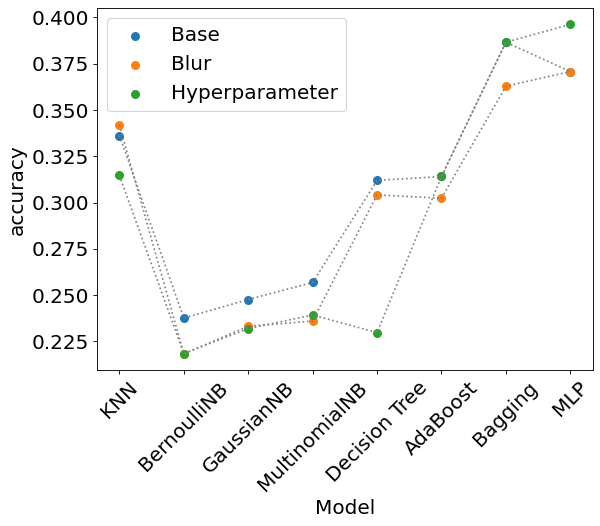

In [ ]:
###########################################################################################################
## Arrange for plotting
###########################################################################################################
x = np.arange(8)
param = 'accuracy'
# BerNB = NB.loc[[0,1,2,3,8],[param]]
# GauNB = NB.loc[[4,5,6,7,9],[param]]
# MulNB = NB.loc[[10,11,12,13,14],[param]]

Base = [KNN_Noblur.loc[0]['accuracy']] + \
        flattenList(NB.loc[[0,4,10],['accuracy']].values.tolist()) + \
        [DT.loc[1]['accuracy']] +\
        [Adaboost.loc[1]['accuracy']] +\
        [Bagging.loc[1]['accuracy']] +\
        [MLP.loc[0]['accuracy']]

hyper = [KNN_Noblur.loc[1]['accuracy']] + \
        flattenList(NB.loc[[8,9,14],['accuracy']].values.tolist()) + \
        [DT_hyp.loc[1]['accuracy']] +\
        [Adaboost_hyp.loc[1]['accuracy']] +\
        [Bagging_hyp.loc[1]['accuracy']] +\
        [MLP_hyp.loc[0]['accuracy']]

blur =  [KNN_Blur.loc[1]['accuracy']] + \
        flattenList(NB.loc[[1,5,11],['accuracy']].values.tolist()) + \
        [DT.loc[7]['accuracy']] +\
        [Adaboost.loc[3]['accuracy']] +\
        [Bagging.loc[3]['accuracy']] +\
        [MLP.loc[1]['accuracy']]

###########################################################################################################
## Plotting 
###########################################################################################################
font = {'size'   : 18}
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('font', **font)

marker_size = 50
plt.scatter(x,Base, s = marker_size, label='Base')
plt.scatter(x,blur, s = marker_size, label='Blur')
plt.scatter(x,hyper, s = marker_size, label='Hyperparameter')

plt.plot(x, Base,':', color = 'gray', label='_nolegend_')
plt.plot(x, blur,':', color = 'gray', label='_nolegend_')
plt.plot(x, hyper,':', color = 'gray', label='_nolegend_')

plt.xticks(x, ['KNN', 'BernoulliNB', 'GaussianNB', 'MultinomialNB', 'Decision Tree', 'AdaBoost', 'Bagging', 'MLP'], rotation = 45)
plt.xlabel('Model')
plt.ylabel(param)
#plt.ylim([0.20, 0.28])
plt.legend()
#plt.legend([None,None, None,"Base", "Blur", "Hyperparameters"],loc='lower right') #bbox_to_anchor=(1.05, 1),
plt.show()

### CNN baseline models

Since the base models did not provide the desired accuracy, we evaluated the CNN models - using default hyperparameters

#### Load files from baseline models

In [ ]:
CNN_32_Adam_256_Blur     =   pd.read_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-Blur-Std.csv"     , sep='\t')
CNN_32_Adam_256_noBlur   =   pd.read_csv("/content/drive/MyDrive/w207/CNN-Adam-Default-Epoch-256-noBlur-Std.csv"   , sep='\t')
CNN_32_Adamax_256_Blur   =   pd.read_csv("/content/drive/MyDrive/w207/CNN-Adamax-Default-Epoch-256-Blur-Std.csv"   , sep='\t')
CNN_32_Adamax_256_noBlur =   pd.read_csv("/content/drive/MyDrive/w207//CNN-Adamax-Default-Epoch-256-noBlur-Std.csv" , sep='\t')
CNN_32_RMSprop_256_Blur  =   pd.read_csv("/content/drive/MyDrive/w207/CNN-RMSprop-Default-Epoch-256-Blur-Std.csv"  , sep='\t')
CNN_32_RMSprop_256_noBlur=   pd.read_csv("/content/drive/MyDrive/w207//CNN-RMSprop-Default-Epoch-256-noBlur-Std.csv", sep='\t')
CNN_32_SGD_256_Blur      =   pd.read_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-Blur-Std.csv"      , sep='\t')
CNN_32_SGD_256_noBlur    =   pd.read_csv("/content/drive/MyDrive/w207/CNN-SGD-Default-Epoch-256-noBlur-Std.csv"    , sep='\t')


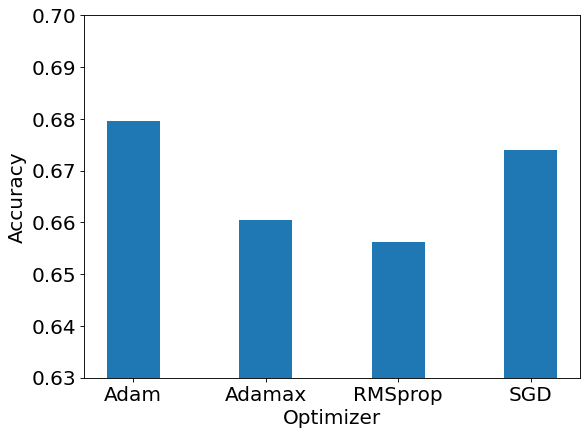

In [ ]:
x = np.arange(4)
param = 'val_accuracy'

noblur =     [max(CNN_32_Adam_256_noBlur[param]), 
              max(CNN_32_Adamax_256_noBlur[param]),
              max(CNN_32_RMSprop_256_noBlur[param]),
              max(CNN_32_SGD_256_noBlur[param]) ] 

width = 0.4

font = {'size'   : 18}
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('font', **font)

plt.bar(x, noblur, width)

plt.xticks(x, ["Adam", "Adamax", "RMSprop", "SGD"])#, rotation = 45)
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.ylim([0.63, 0.7])

plt.show()


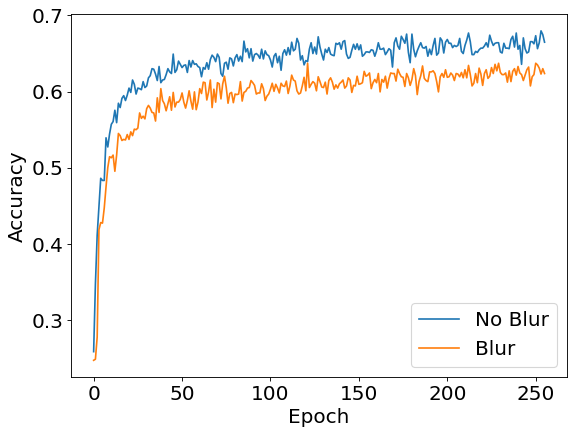

In [ ]:
x = np.arange(4)
param = 'val_accuracy'


font = {'size'   : 18}
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('font', **font)

plt.plot( np.arange(256), CNN_32_Adam_256_noBlur[param].values.tolist() )
plt.plot( np.arange(256), CNN_32_Adam_256_Blur[param].values.tolist() )

#plt.xticks(x, ["Adam", "Adamax", "RMSprop", "SGD"])#, rotation = 45)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.59, 0.7])
#plt.legend(["No Blur", "Blur"],loc='upper right') #bbox_to_anchor=(1.05, 1),
plt.legend(["No Blur", "Blur"])
#plt.grid()

plt.show()


### CNN Hyperparameters

we further analyzed the results of CNN model with tuned hyperparameters.


#### Load files from CNN models

In [ ]:
CNN_32_Adam    =   pd.read_csv("/content/drive/MyDrive/w207/CNN_32-Adam-noBlur-Std.csv"  , sep='\t')
CNN_64_Adam    =   pd.read_csv("/content/drive/MyDrive/w207/CNN_64-Adam-noBlur-Std.csv"  , sep='\t')
CNN_128_Adam   =   pd.read_csv("/content/drive/MyDrive/w207/CNN_128-Adam-noBlur-Std.csv" , sep='\t')
CNN_256_Adam   =   pd.read_csv("/content/drive/MyDrive/w207/CNN_256-Adam-noBlur-Std.csv" , sep='\t')
CNN_512_Adam   =   pd.read_csv("/content/drive/MyDrive/w207/CNN_512-Adam-noBlur-Std.csv" , sep='\t')
CNN_1024_Adam  =   pd.read_csv("/content/drive/MyDrive/w207/CNN_1024-Adam-noBlur-Std.csv", sep='\t')


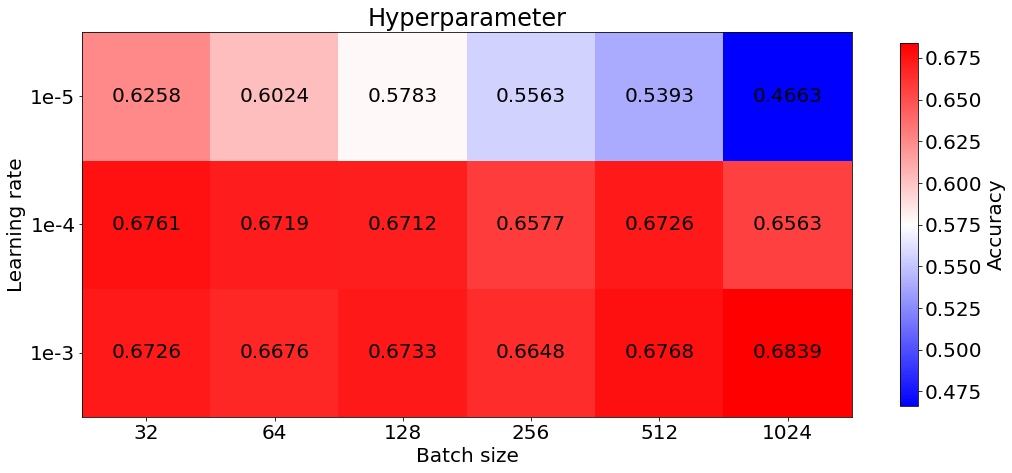

In [ ]:
batch_size = [32, 64, 128, 256, 512, 1024]
learning_rate = ['1e-3', '1e-4', '1e-5']

hyper_param = np.empty((3,6))
i=0
param = 'val_accuracy'
for n,bs in enumerate(batch_size):
    for lr in np.arange(3,6):
        buffer = globals()['CNN_%d_Adam'%bs]
        hyper_param[lr-3][n]  = max(buffer[buffer['learning_rate'] == 10**float(-1*lr)][param])

font = {'size'   : 20}
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (15,9))
im = ax.imshow(hyper_param, cmap=plt.cm.bwr)
#im = ax.pcolor(hyper_param, cmap=plt.cm.Blues)
#heatmap = ax.pcolor(hyper_param, cmap=plt.cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(len(batch_size)))
ax.set_yticks(np.arange(len(learning_rate)))
# ... and label them with the respective list entries
ax.set_xticklabels(batch_size)
ax.set_yticklabels(learning_rate)

ax.set_xlabel('Batch size')
ax.set_ylabel('Learning rate')
# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels())#, rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(learning_rate)):
    for j in range(len(batch_size)):
        text = ax.text(j, i, "%.4f"%hyper_param[i, j],
                       ha="center", va="center", color="k")
        

cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('Accuracy')
ax.invert_yaxis()

ax.set_title("Hyperparameter")
fig.tight_layout()
plt.show()

Text(1.8, 0.59, 'Batch size')

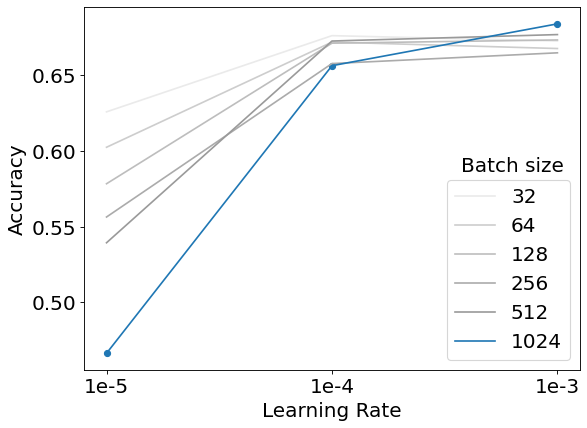

In [ ]:
font = {'size'   : 18}
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('font', **font)

plt.plot(np.fliplr(hyper_param.T)[0] , color='#eaeaea')
plt.plot(np.fliplr(hyper_param.T)[1] , color='#cdcdcd')
plt.plot(np.fliplr(hyper_param.T)[2] , color='#bdbdbd')
plt.plot(np.fliplr(hyper_param.T)[3] , color='#ababab')
plt.plot(np.fliplr(hyper_param.T)[4] , color='#9a9a9a')
plt.plot(np.fliplr(hyper_param.T)[5] )
plt.scatter(np.arange(3),np.fliplr(hyper_param.T)[5], s=30)
plt.legend(['32', '64', '128', '256', '512', '1024'])
plt.xticks([0,1,2], ["1e-5", '1e-4', '1e-3'])
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.text(1.8, 0.59, 'Batch size',
                       ha="center", va="center", color="k")